# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
! pip install JSAnimation

In [2]:
# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [3]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



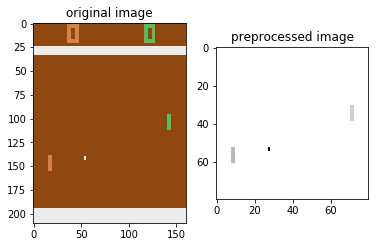

In [4]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # conv1 : 80 x 80 -> 40 x 40
        self.conv1 = nn.Conv2d(2, 4, kernel_size=2, stride=2)
        # conv2 : 40 x 40 -> 20 x 20
        self.conv2 = nn.Conv2d(4, 8, kernel_size=2, stride=2)
        # conv3 : 20 x 20 -> 10 x 10
        self.conv3 = nn.Conv2d(8, 16, kernel_size=2, stride=2)
        # conv4 : 10 x 10 ->  5 x  5
        self.conv4 = nn.Conv2d(16, 32, kernel_size=2, stride=2)
        self.size = 32 * 5 * 5
        
        # 1 fully connected layer
        self.fc1 = nn.Linear(self.size, 64)
        self.fc2 = nn.Linear(64, 8)
        self.fc3 = nn.Linear(8, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = x.view(-1, self.size)
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))  
        x = self.sig(self.fc3(x))
        return x

# use your own policy!
policy=Policy().to(device)
# policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


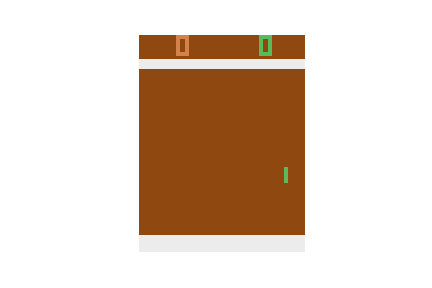
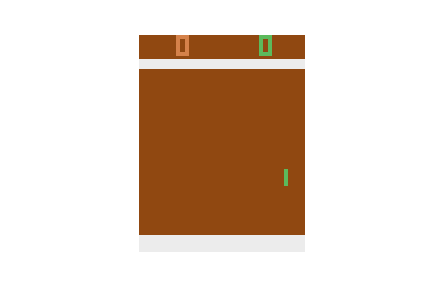
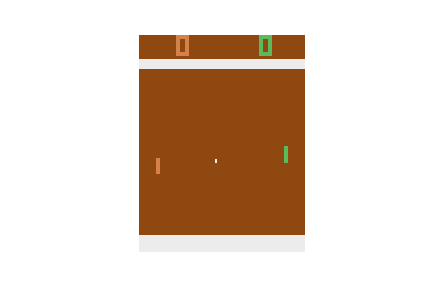
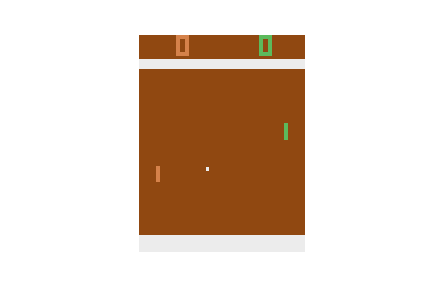
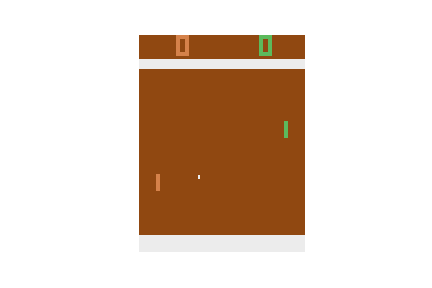
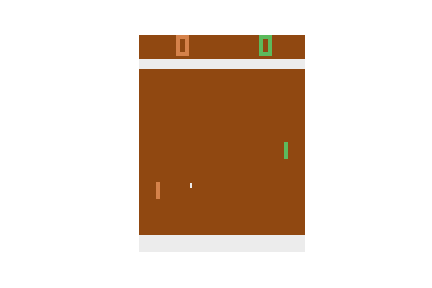
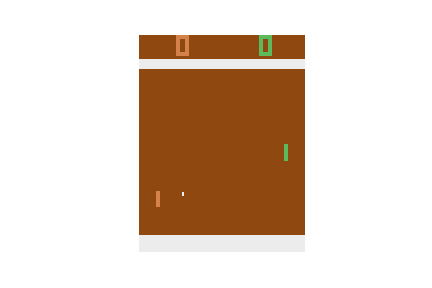
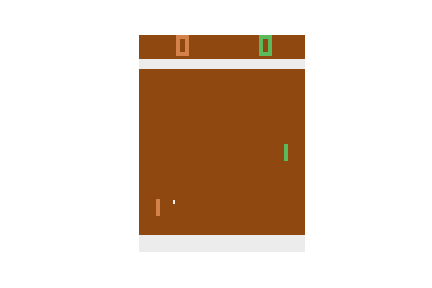
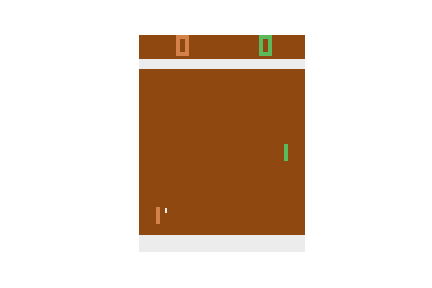
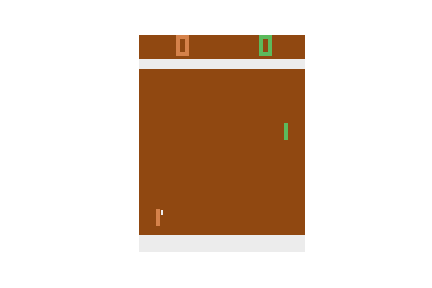
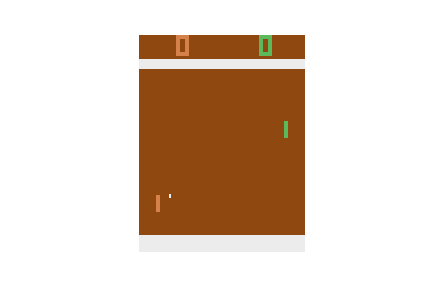
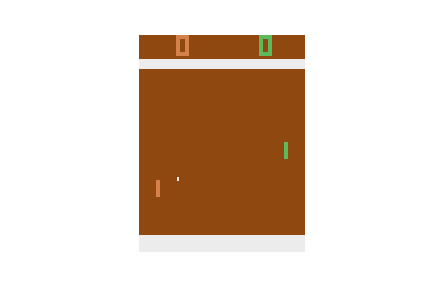
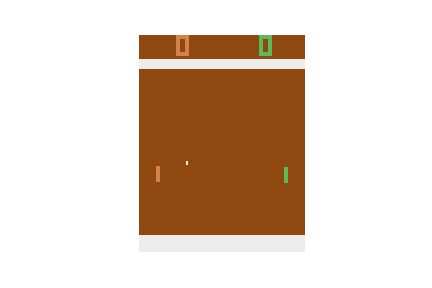
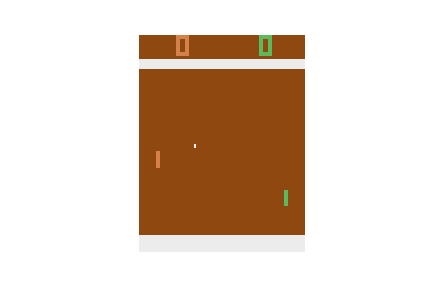
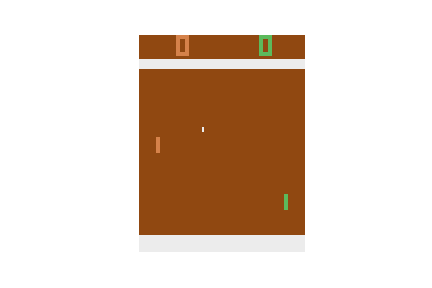
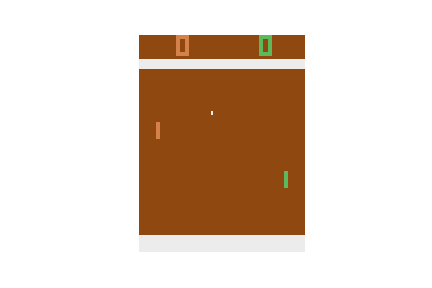
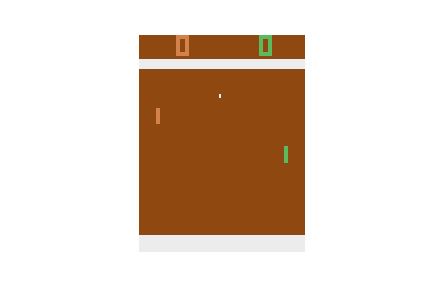
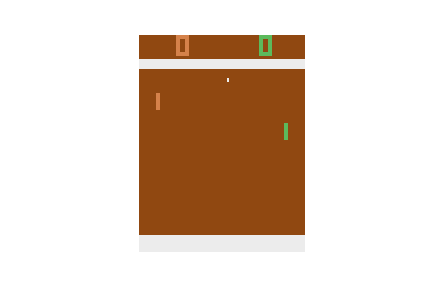
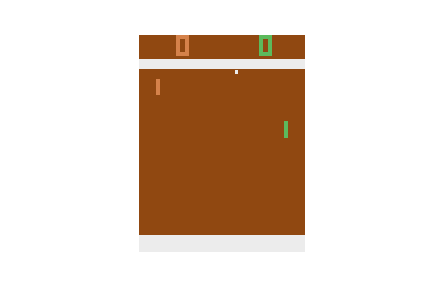
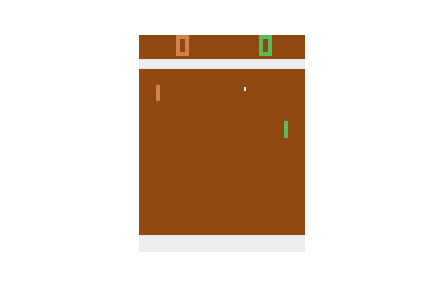
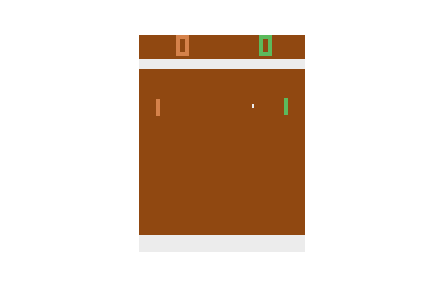
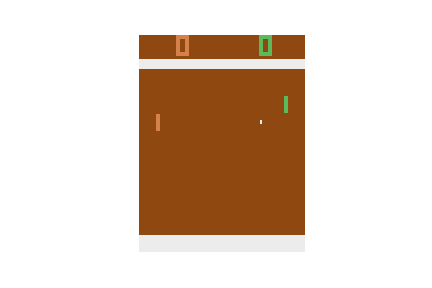
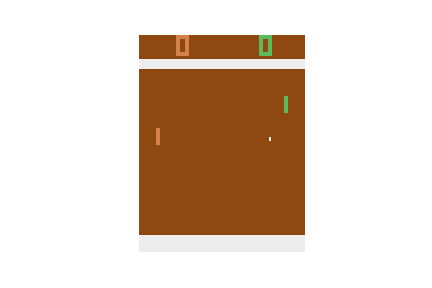
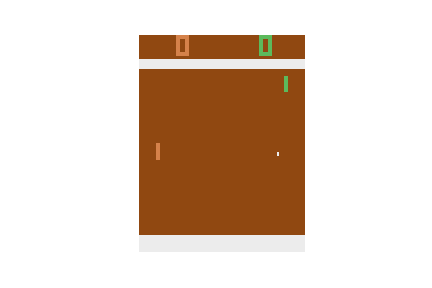
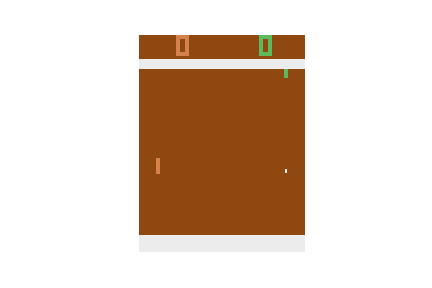
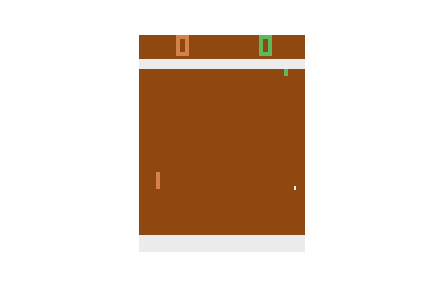
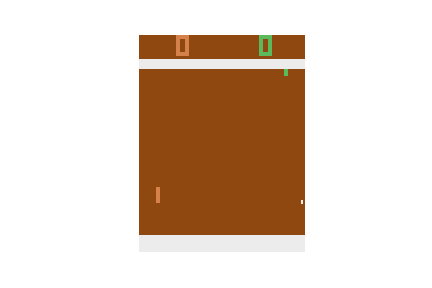
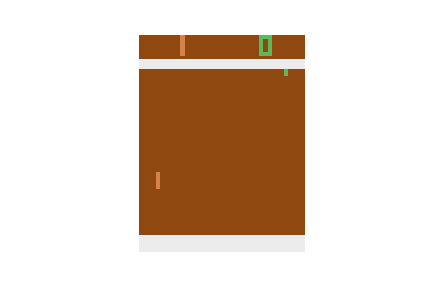
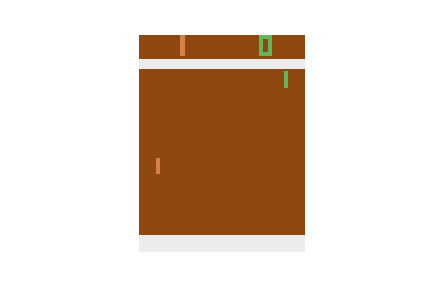
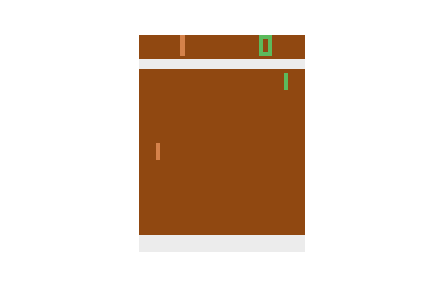
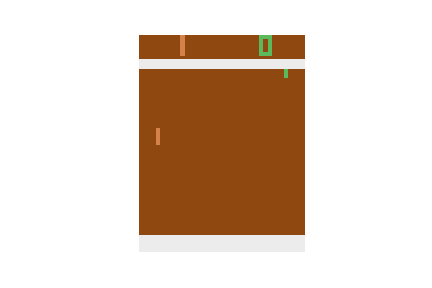
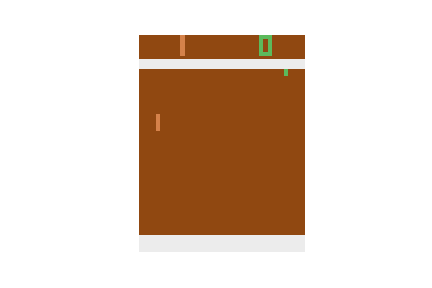
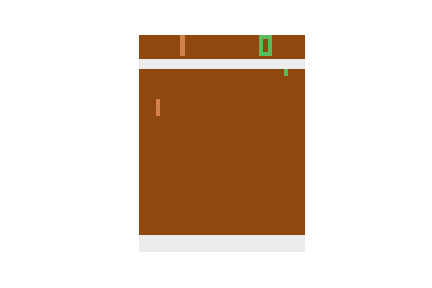
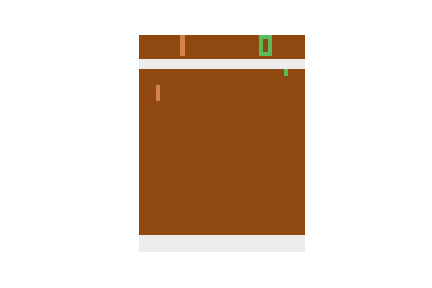
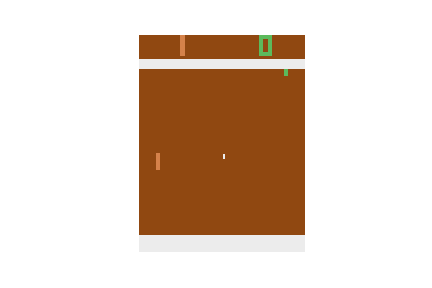
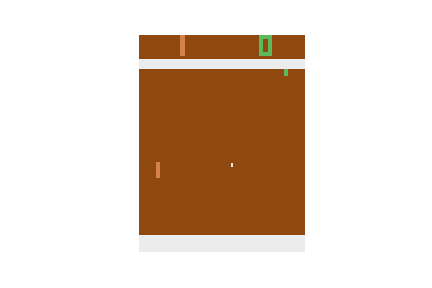
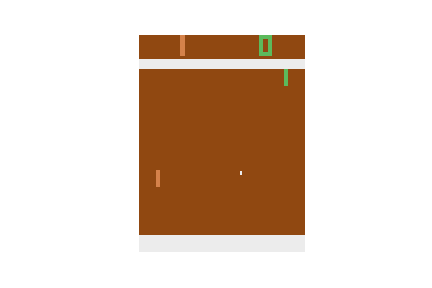
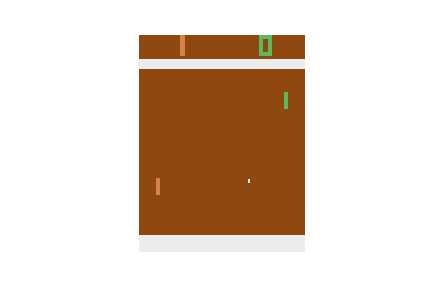
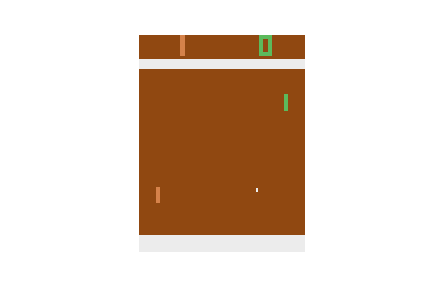
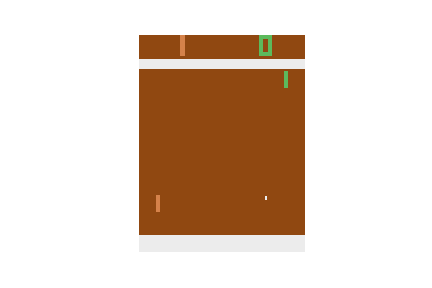
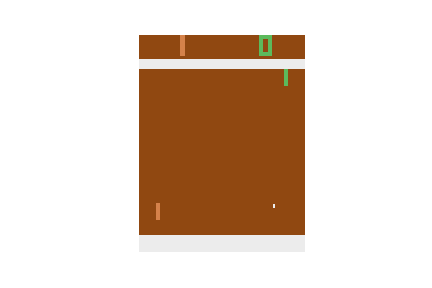
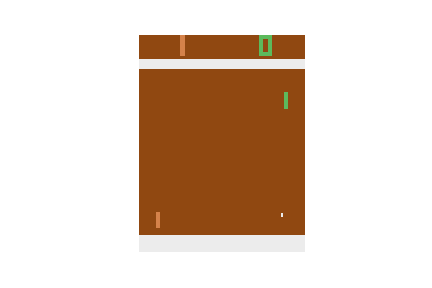
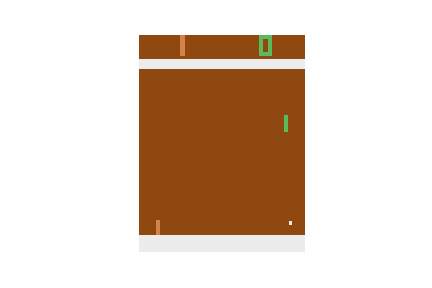
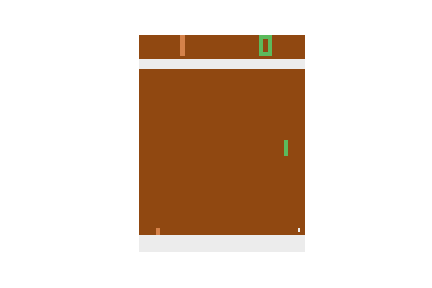
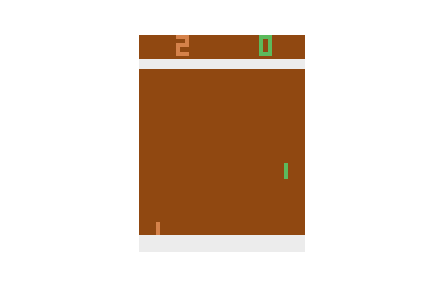
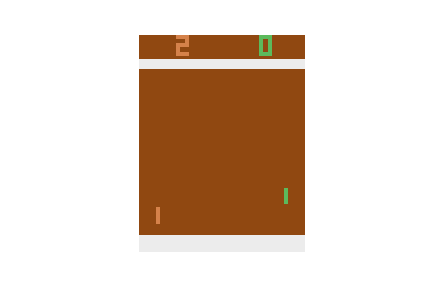
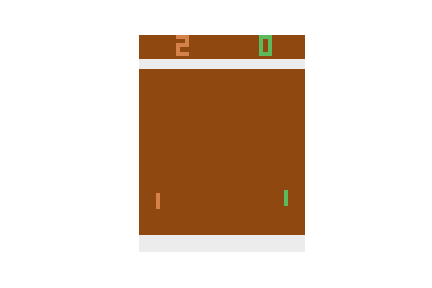
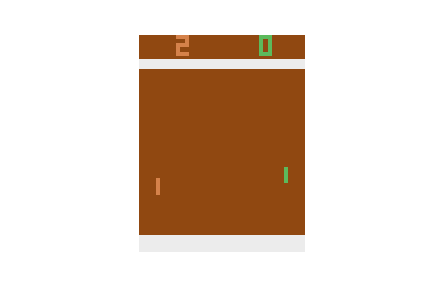
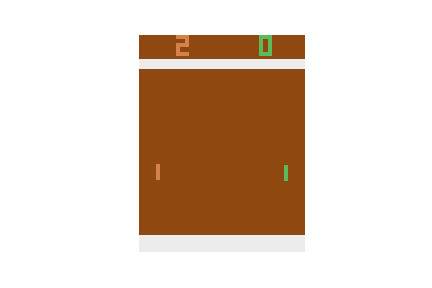
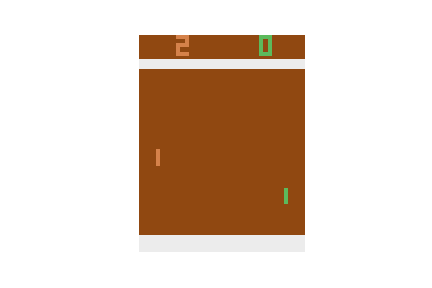
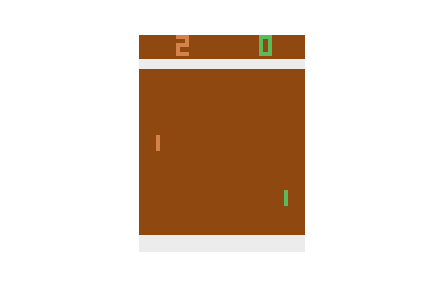
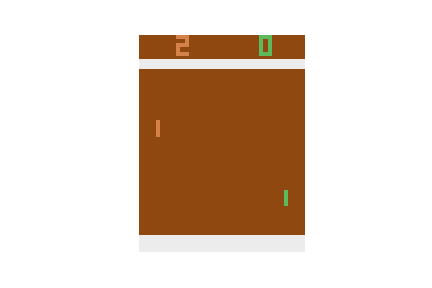
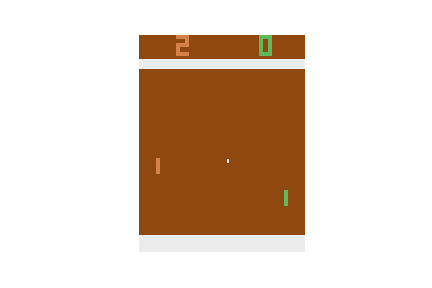
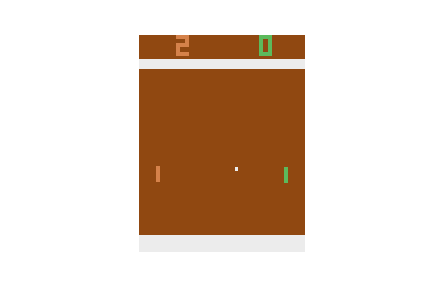
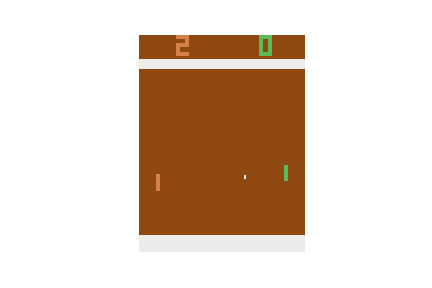
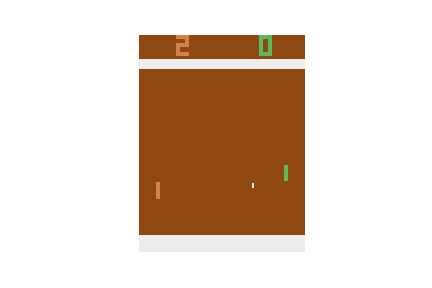
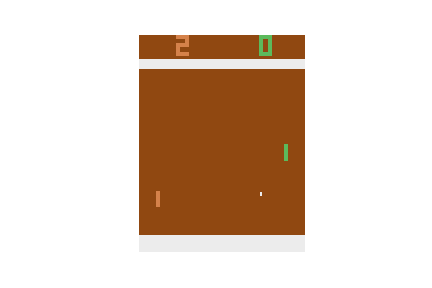
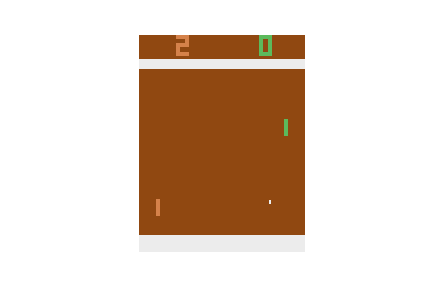
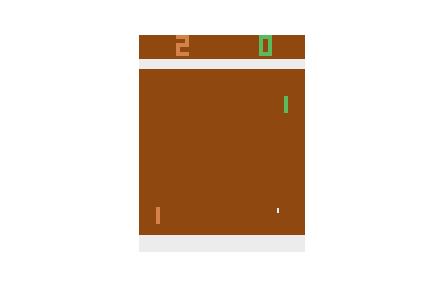
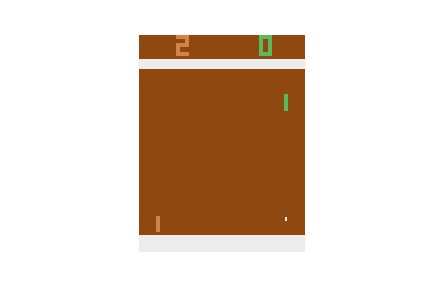
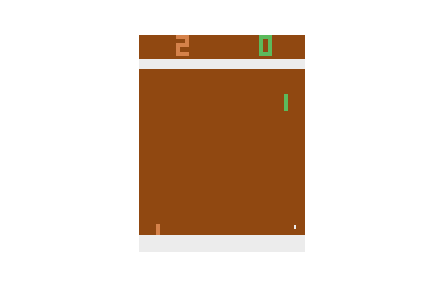
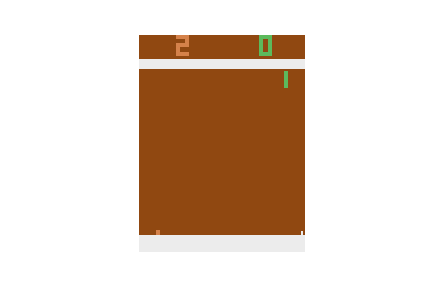
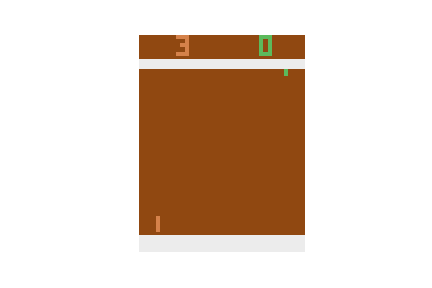
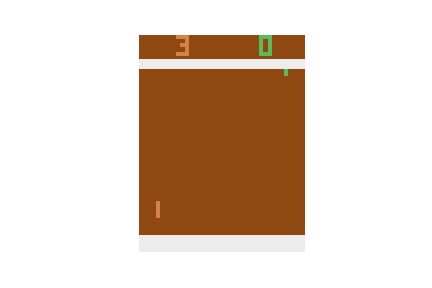
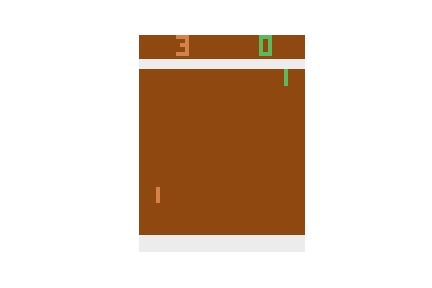
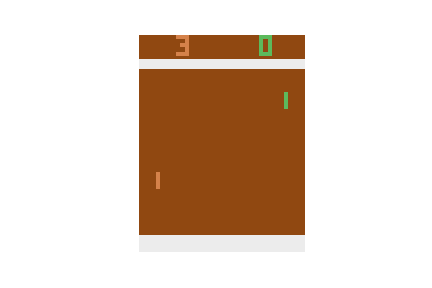
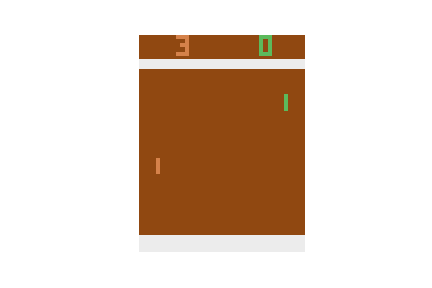
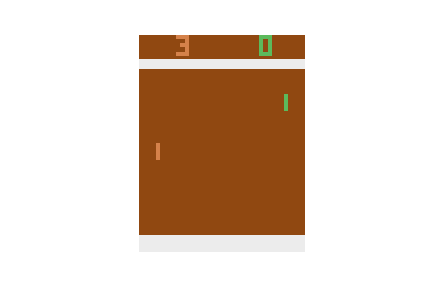
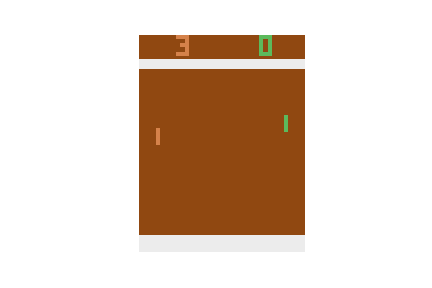
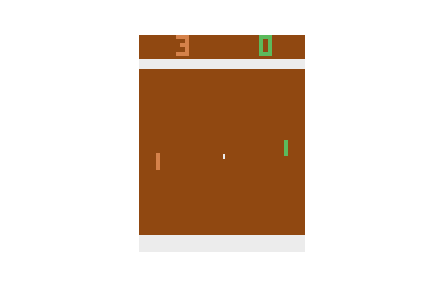
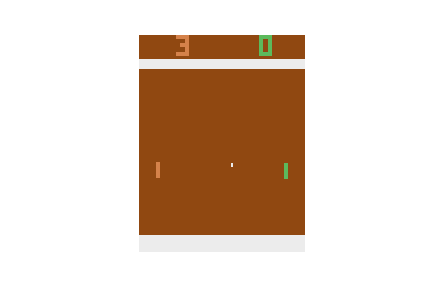
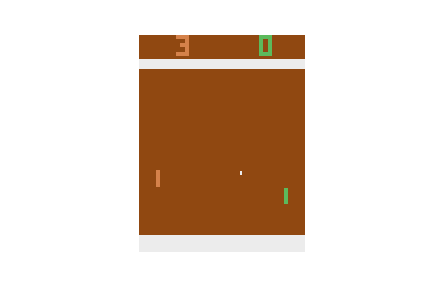
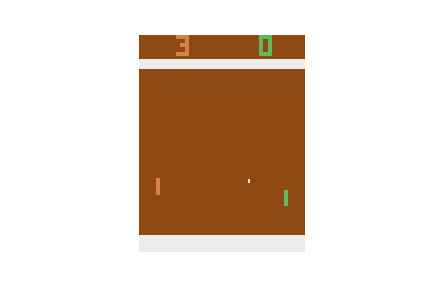
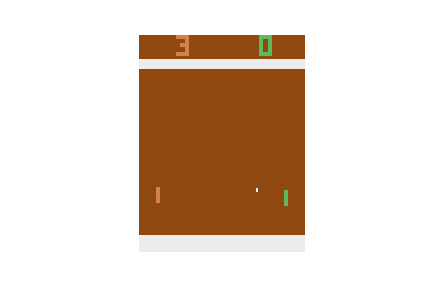
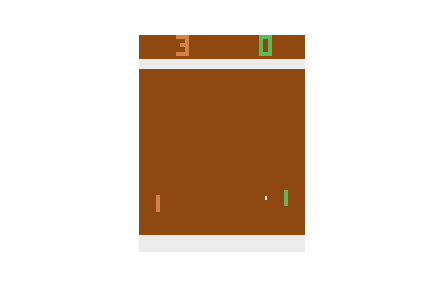
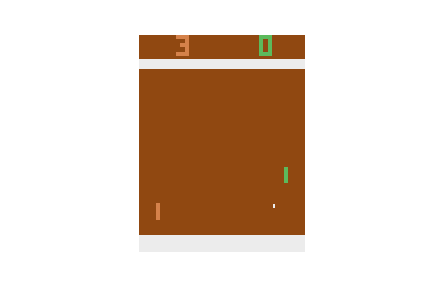
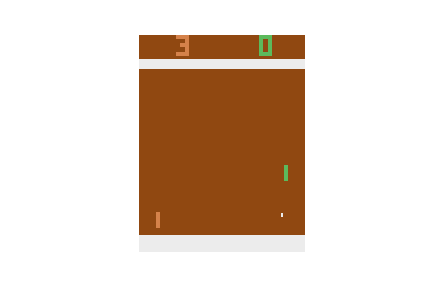
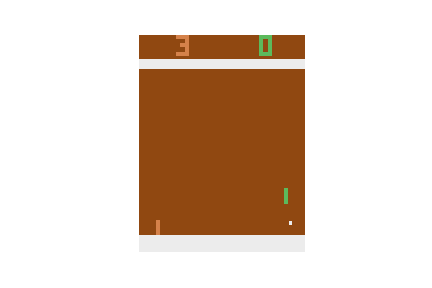
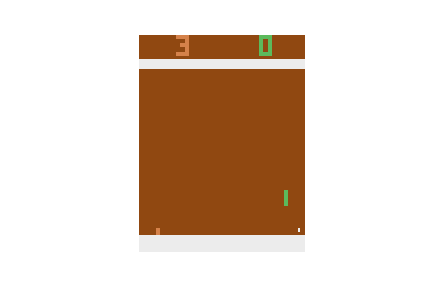
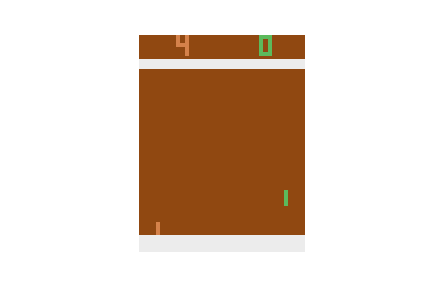
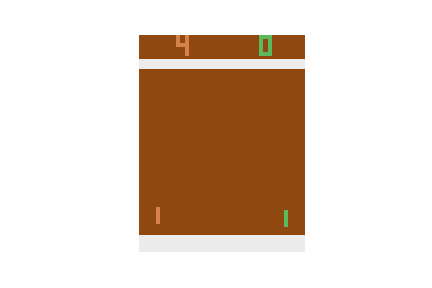
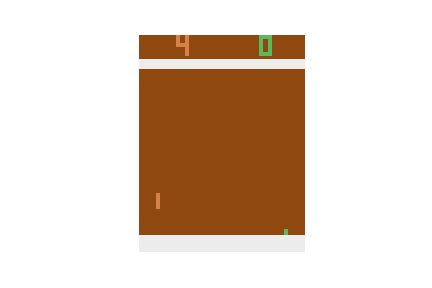
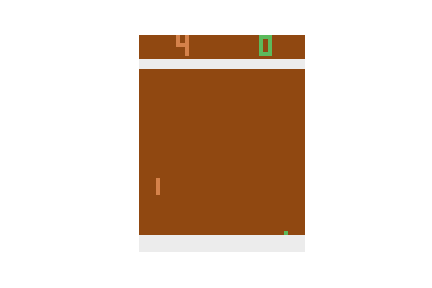
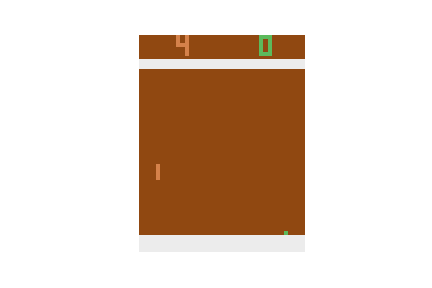
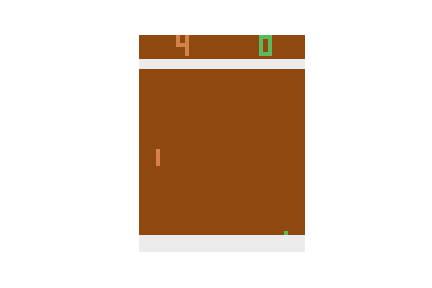
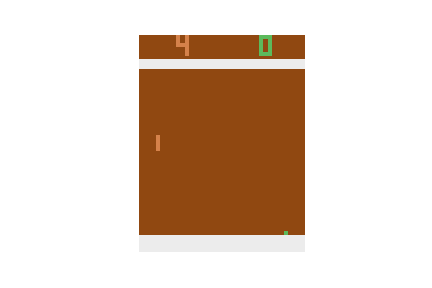
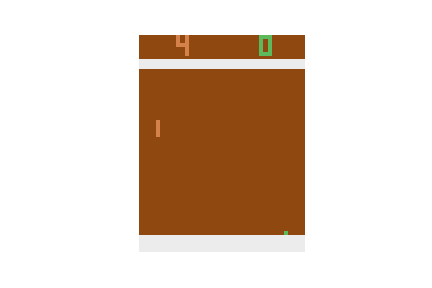
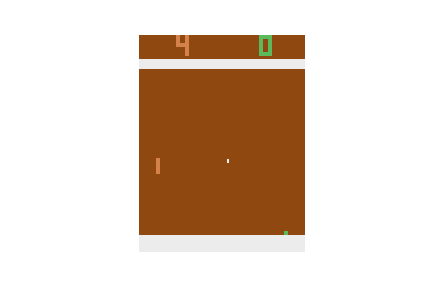
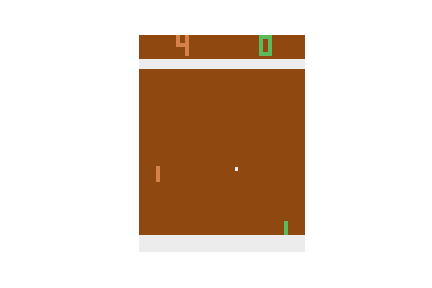
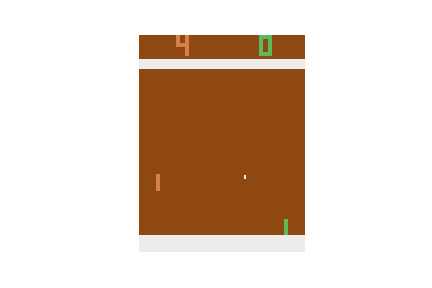
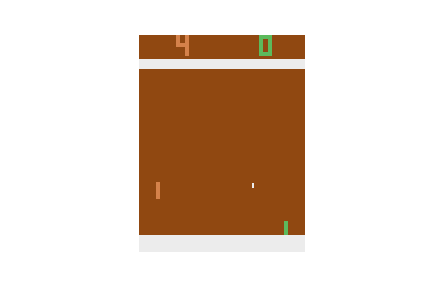
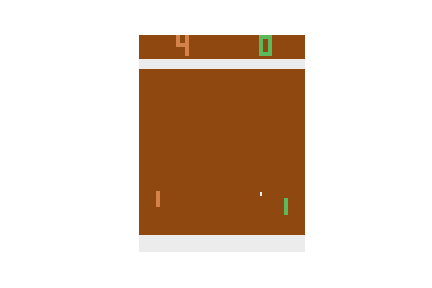
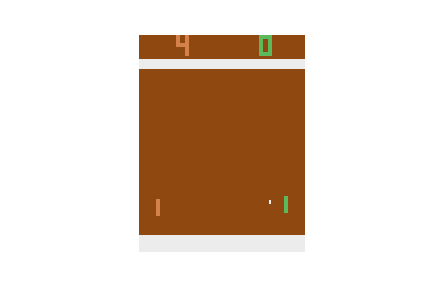
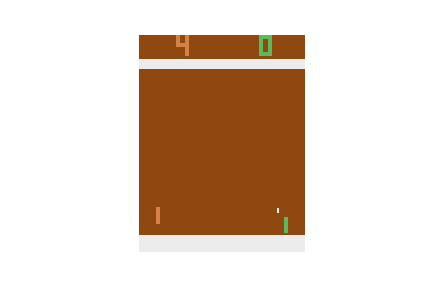
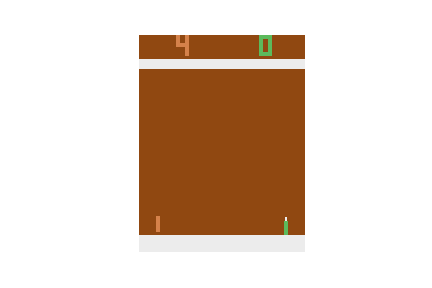
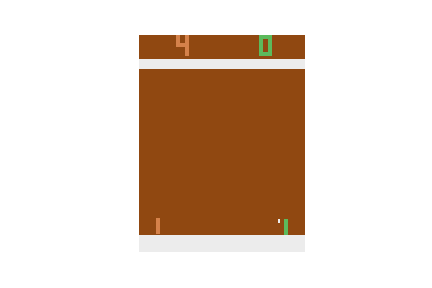
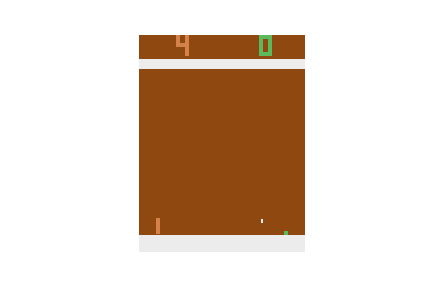
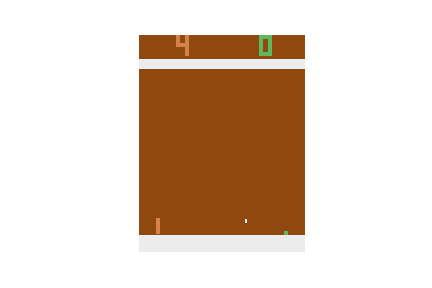
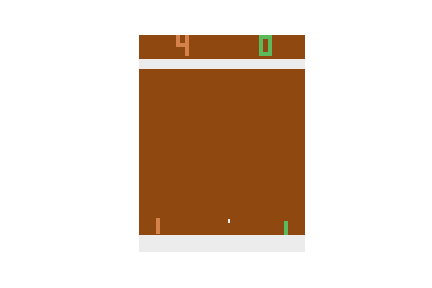
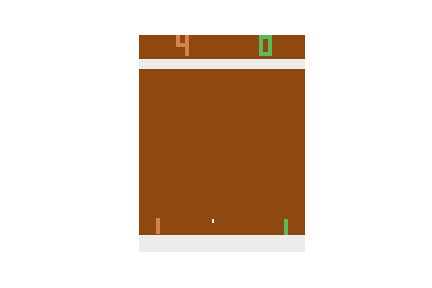
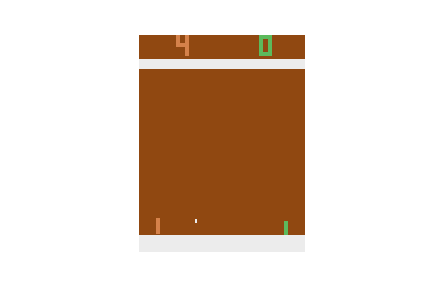
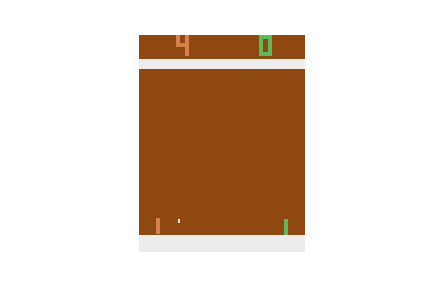
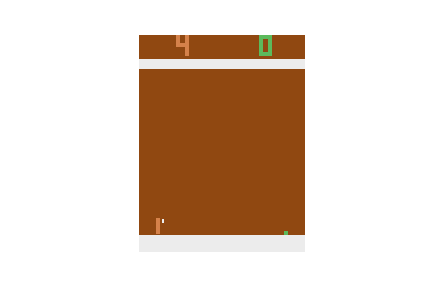
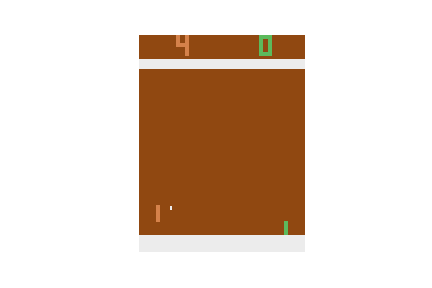
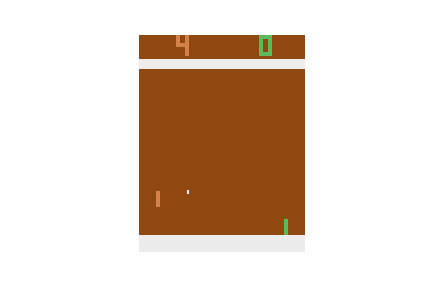
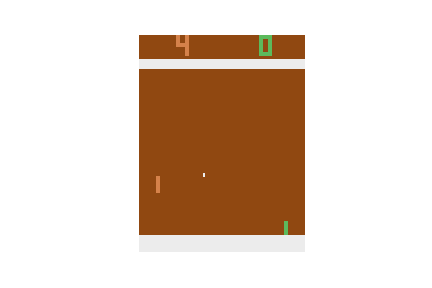
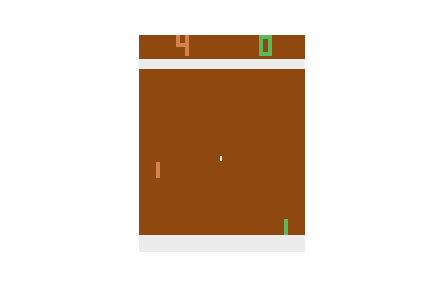
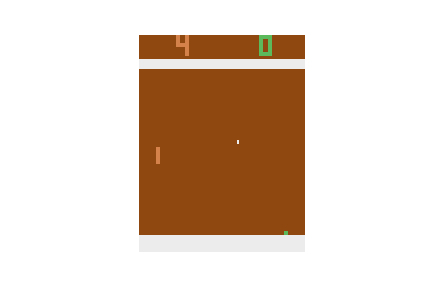
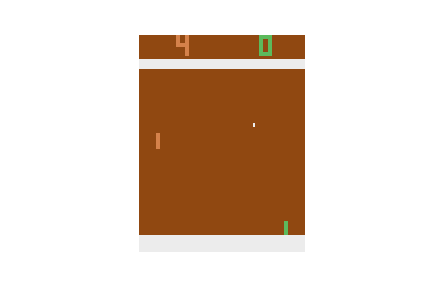
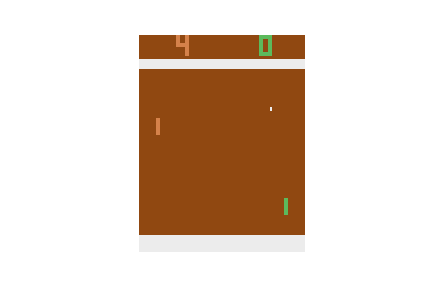
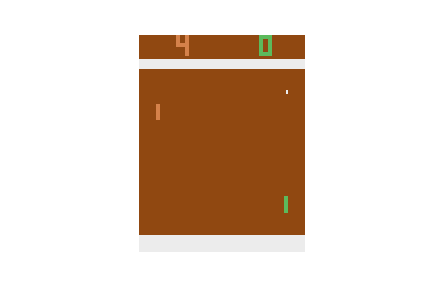
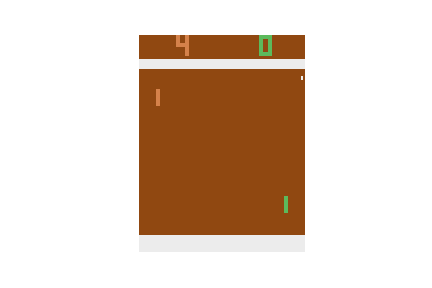
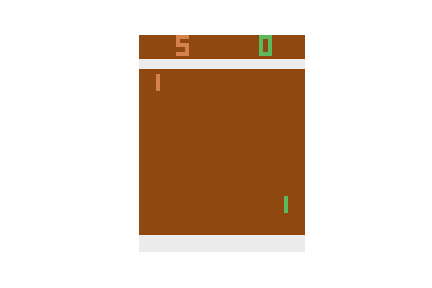
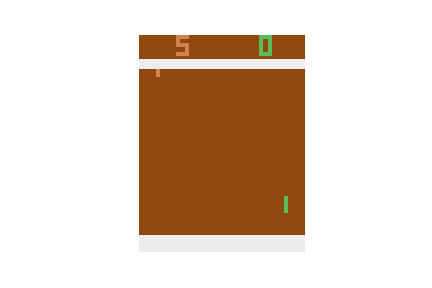
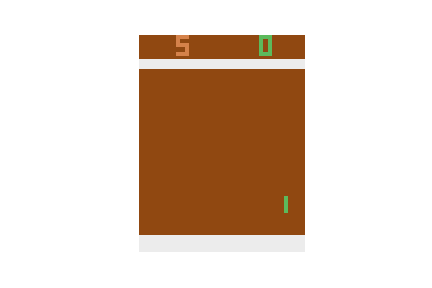
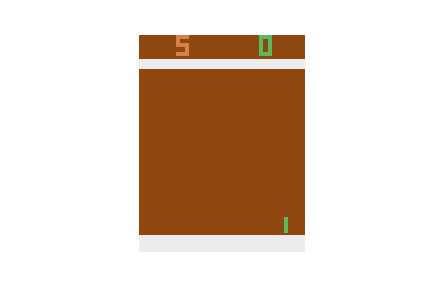
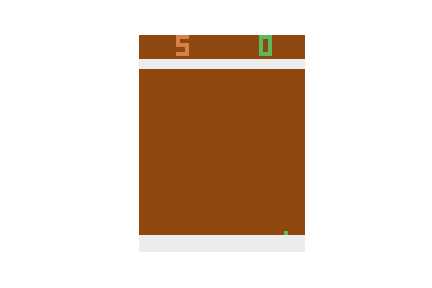
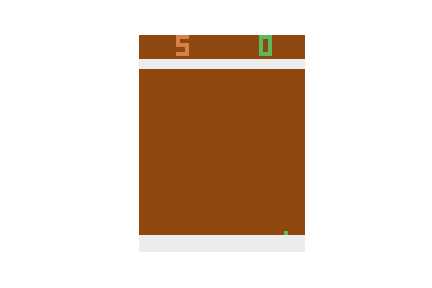
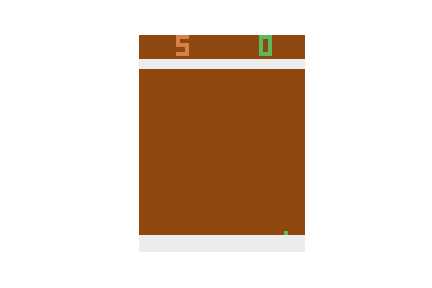
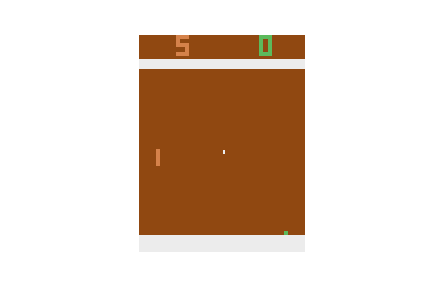
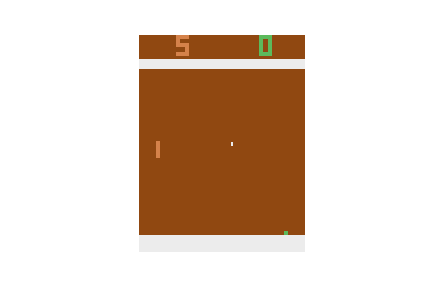
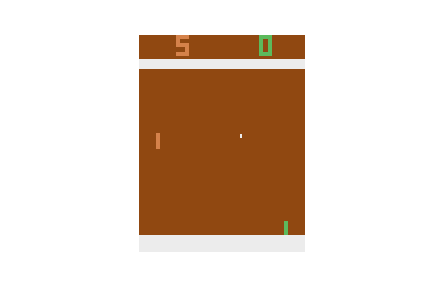
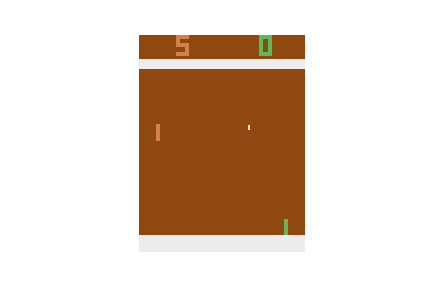
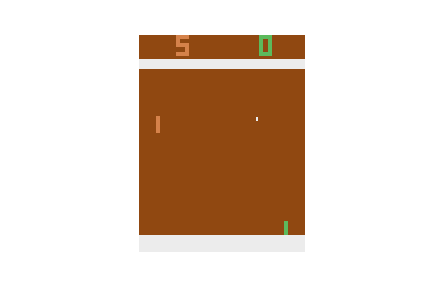
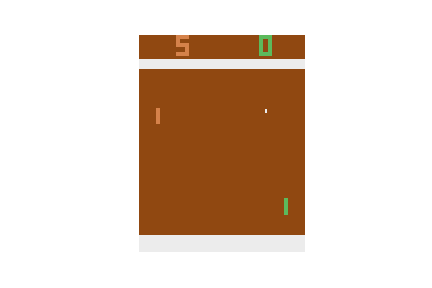
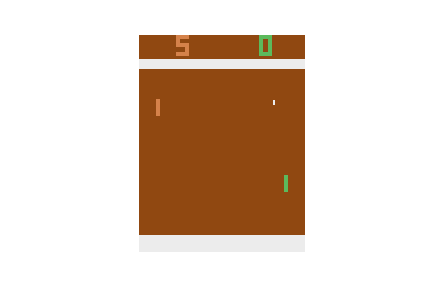
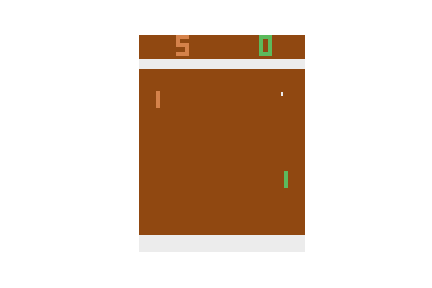
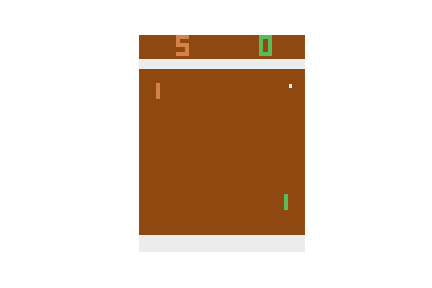
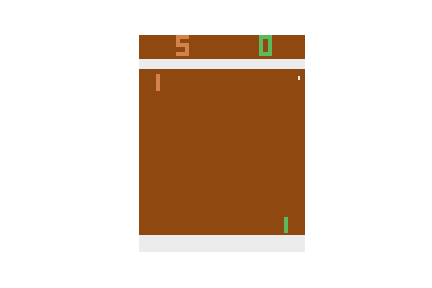
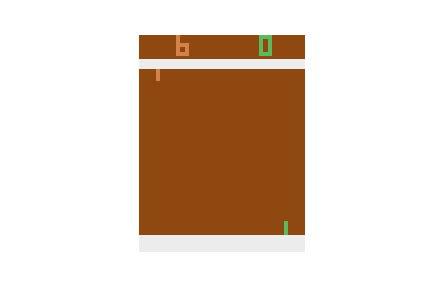
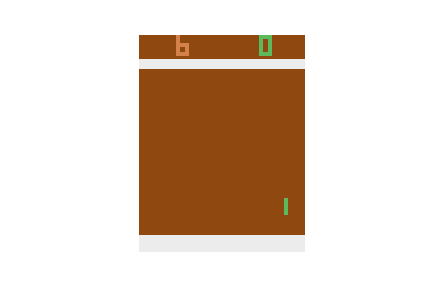
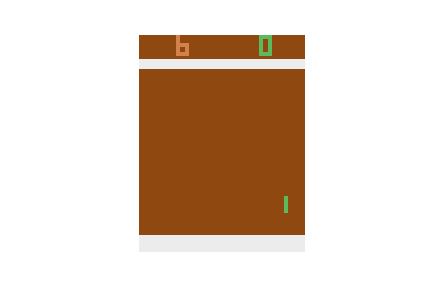
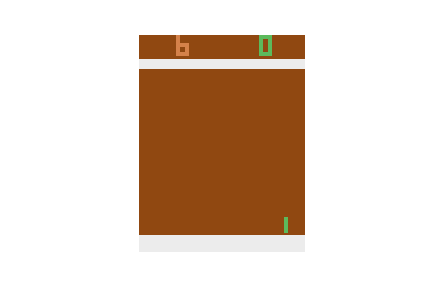
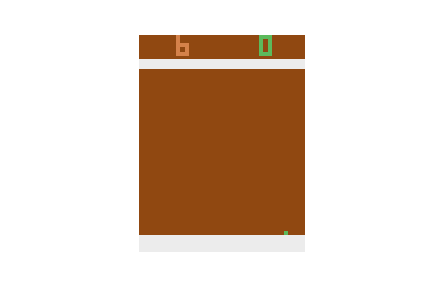
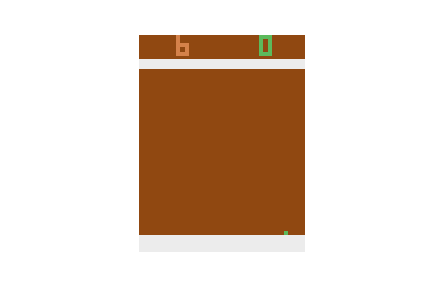
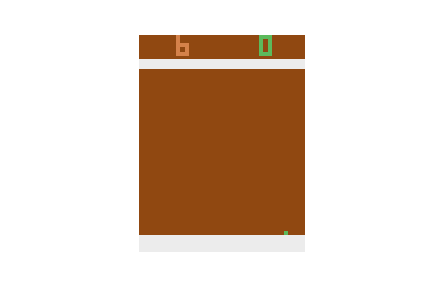
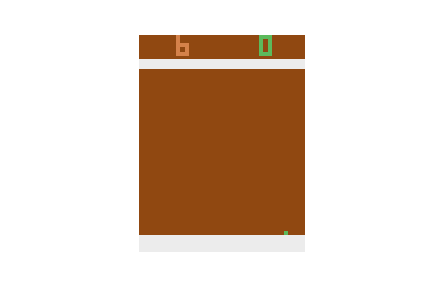
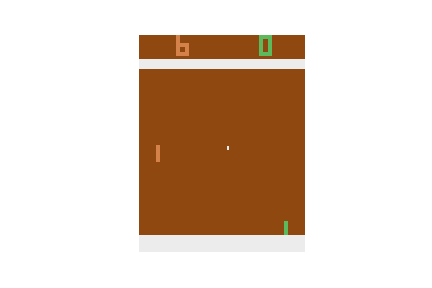
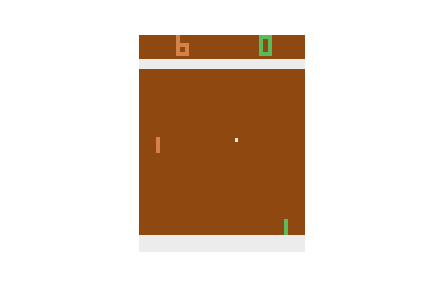
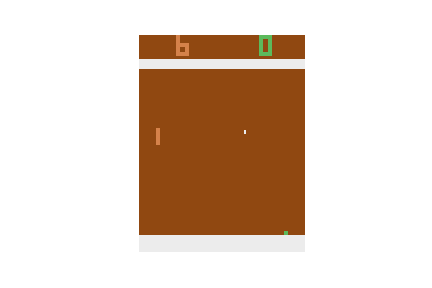
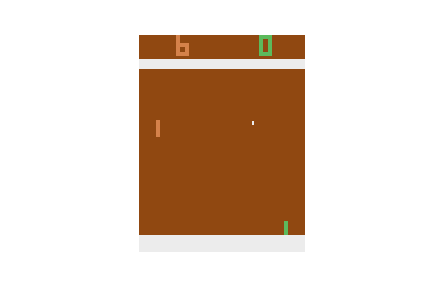
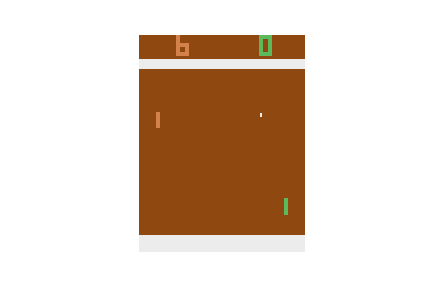
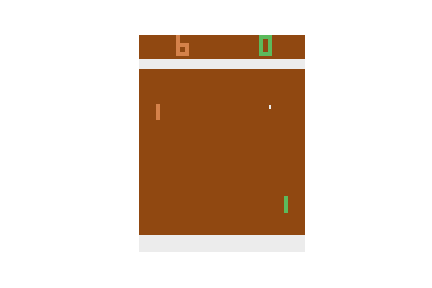
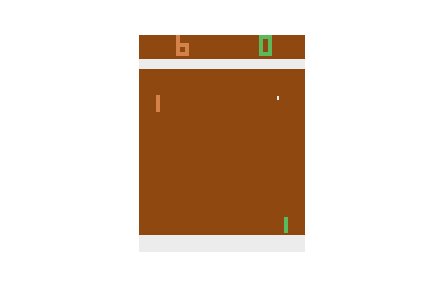
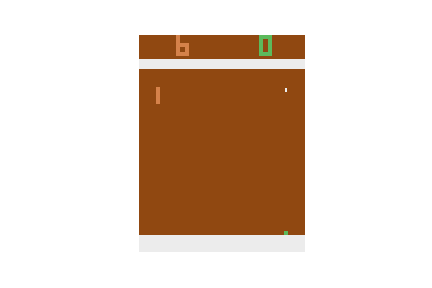
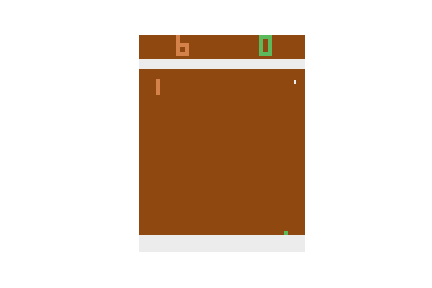
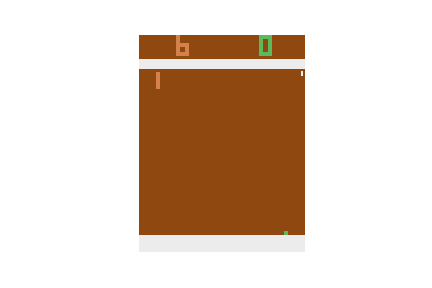
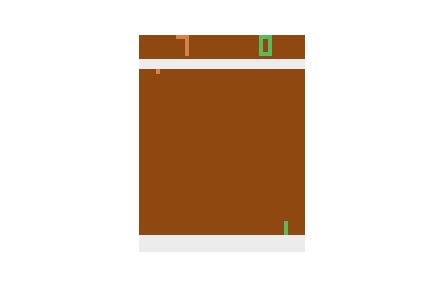
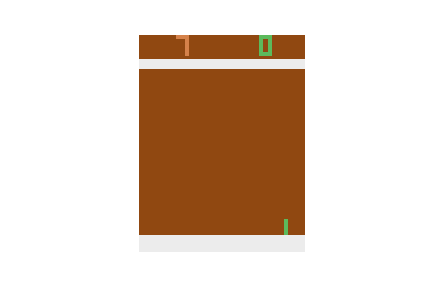
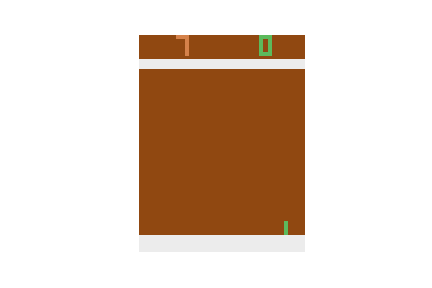
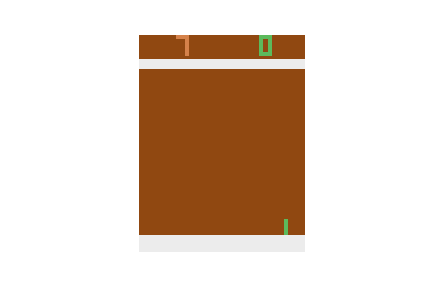
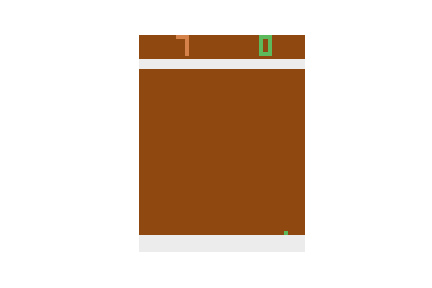
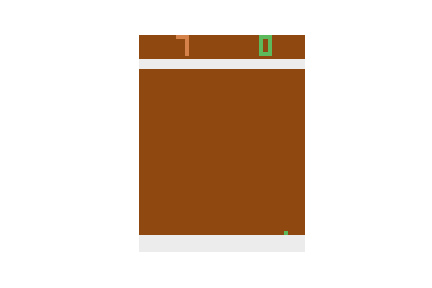
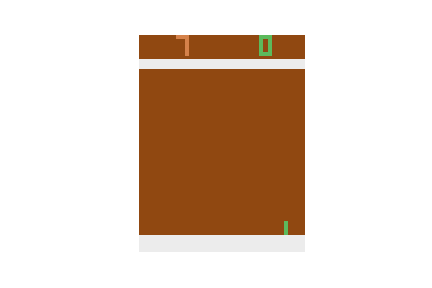
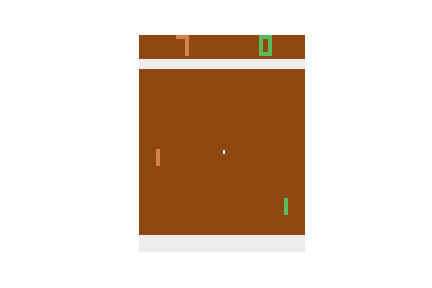
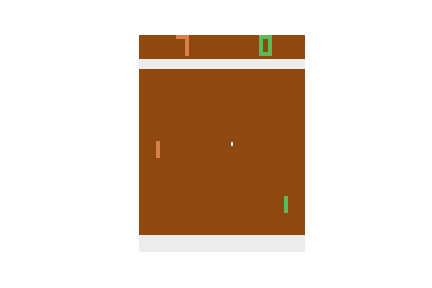
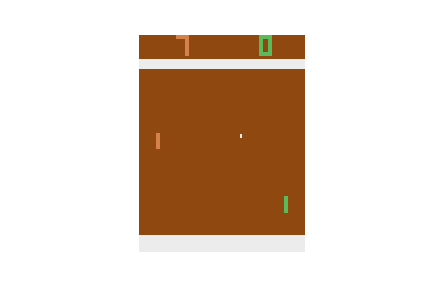
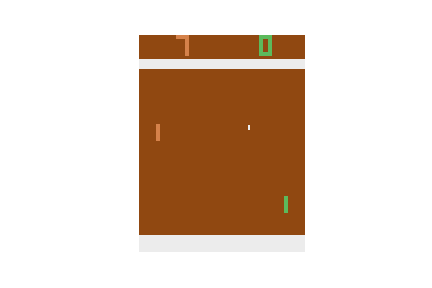
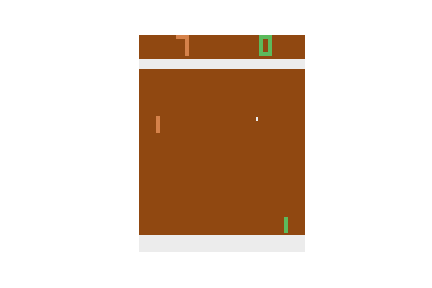
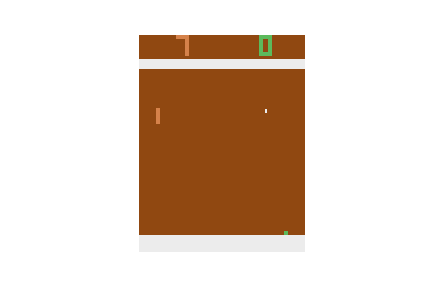
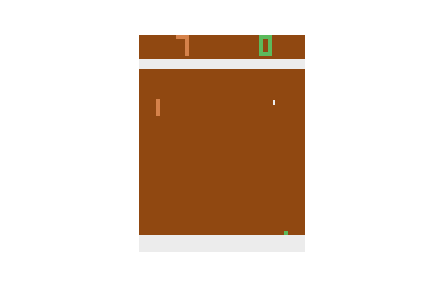
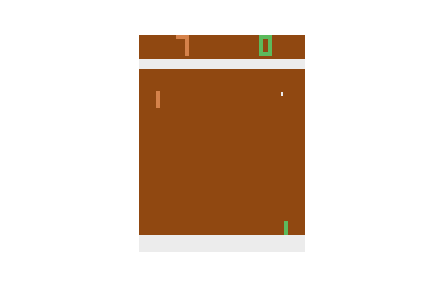
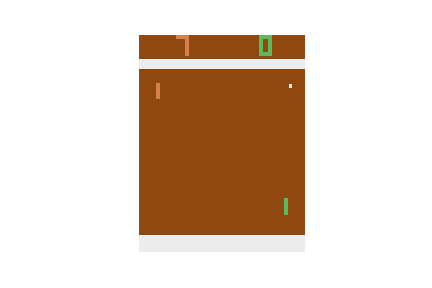
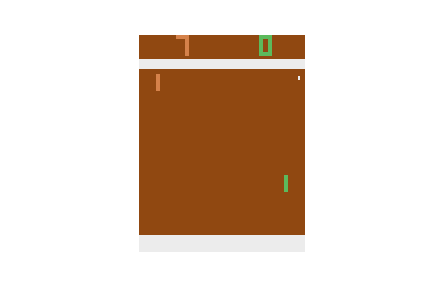
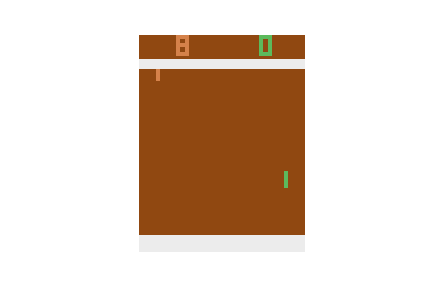
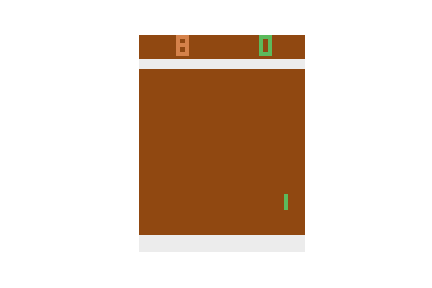
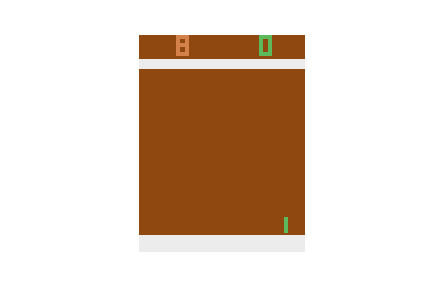
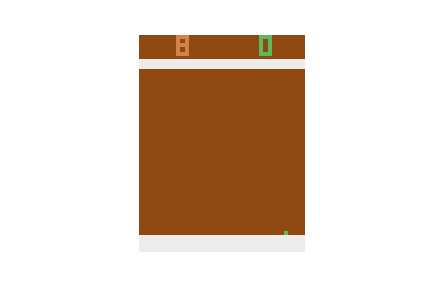
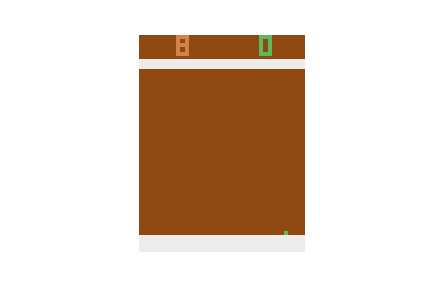
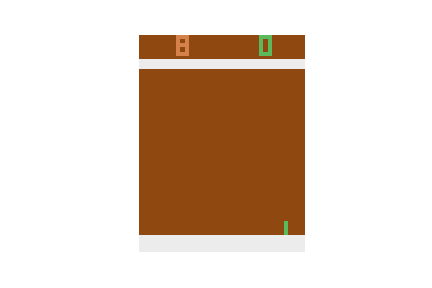
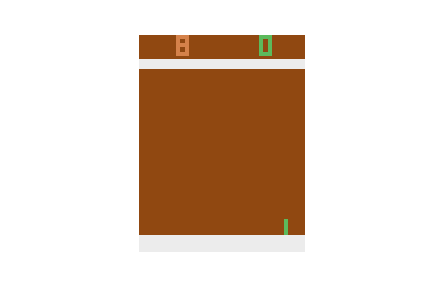
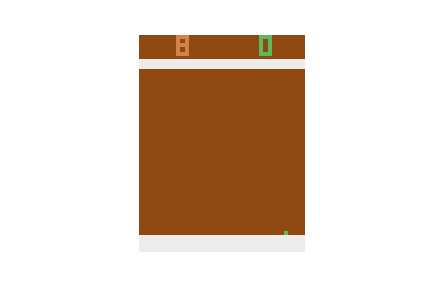
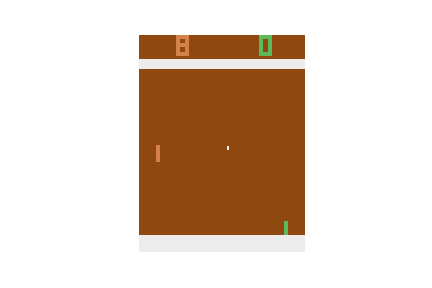
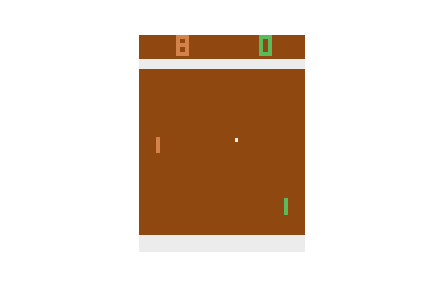
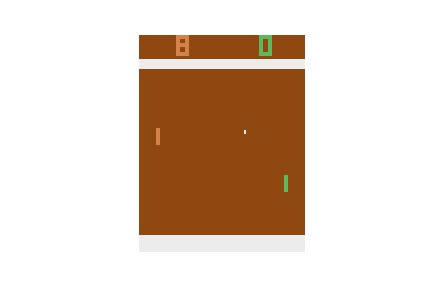
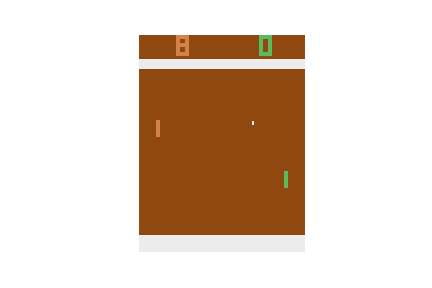
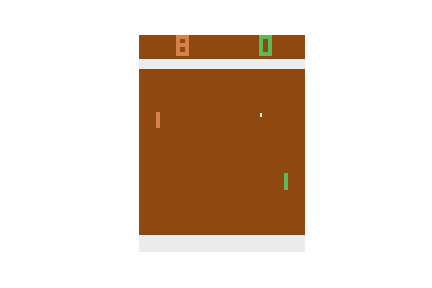
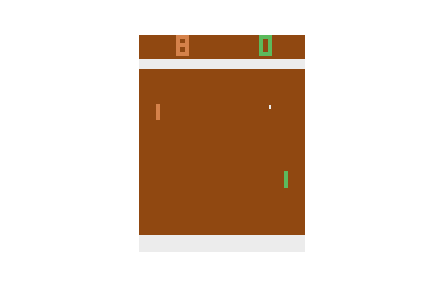
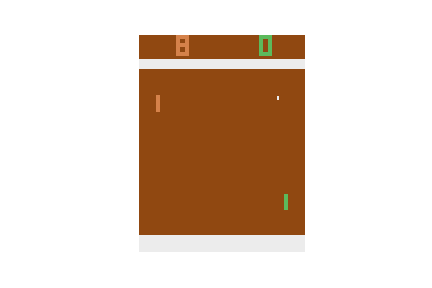
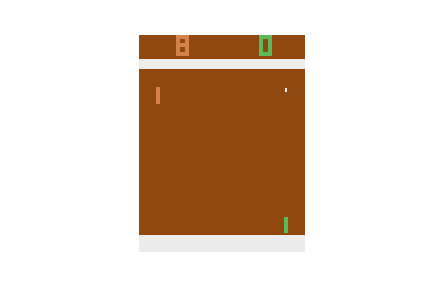
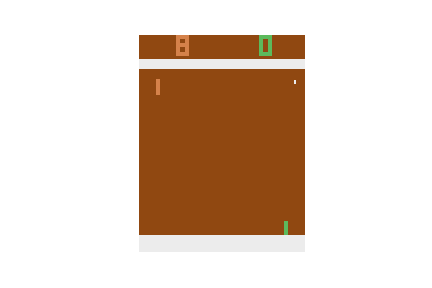
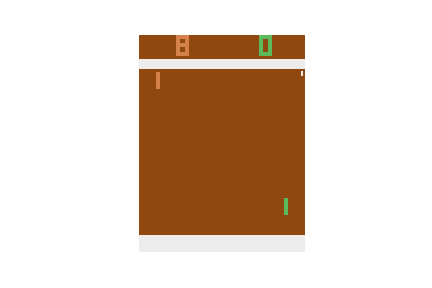
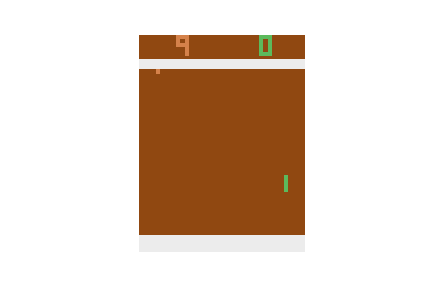
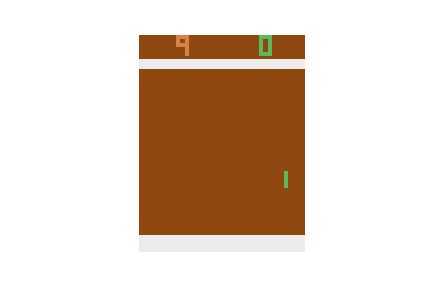
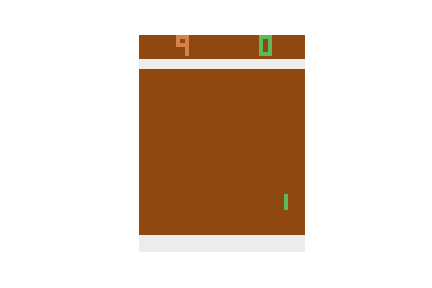
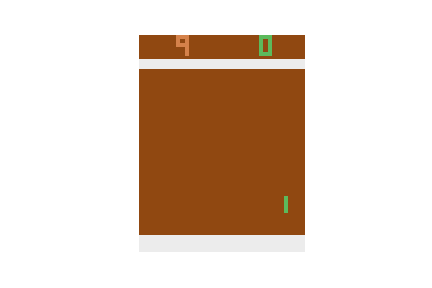
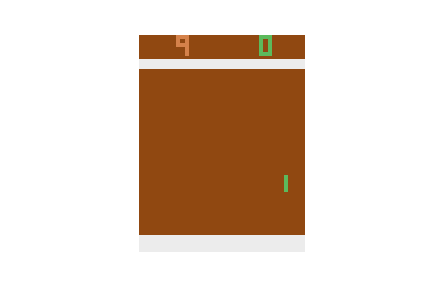
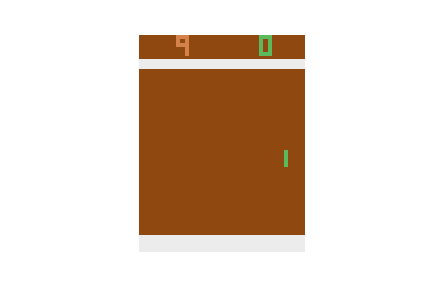
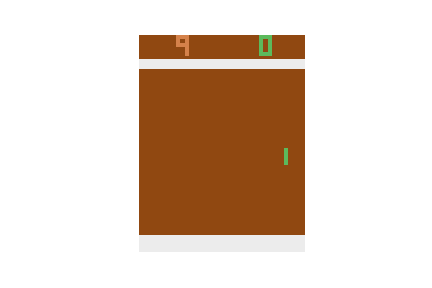
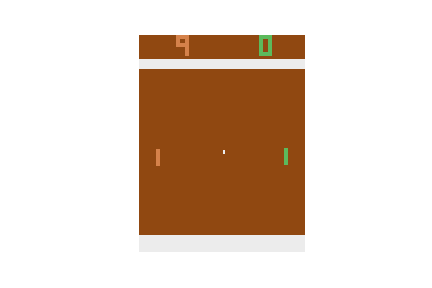
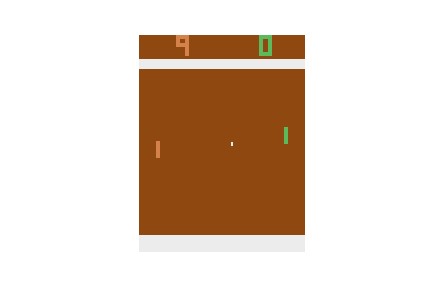
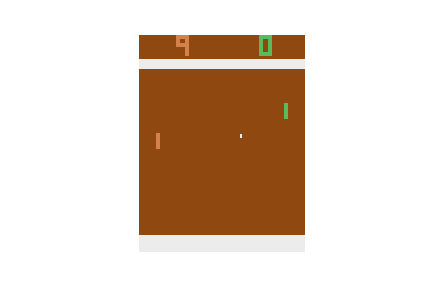
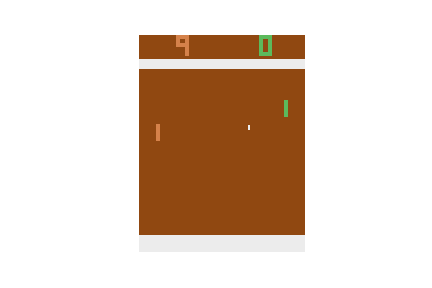
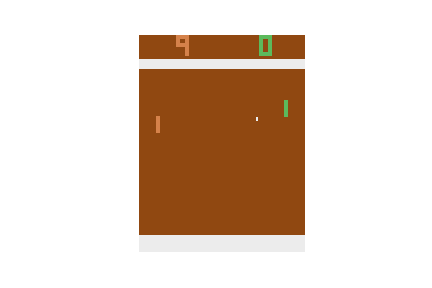
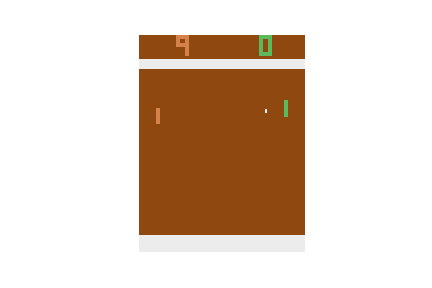
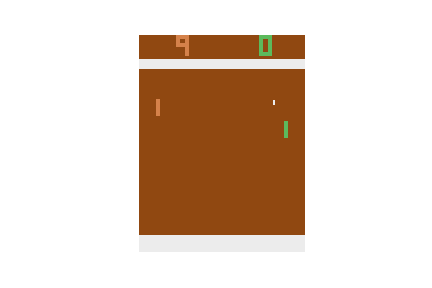
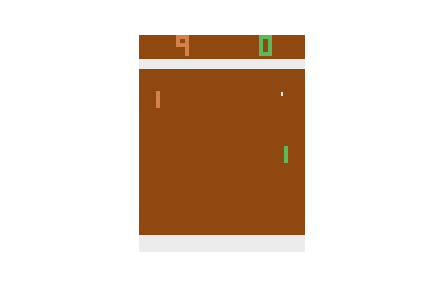
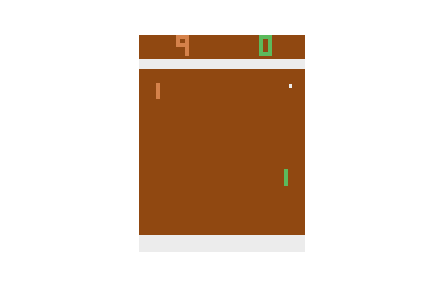
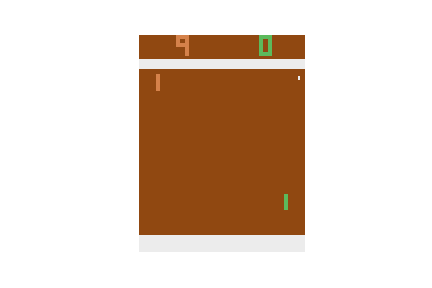
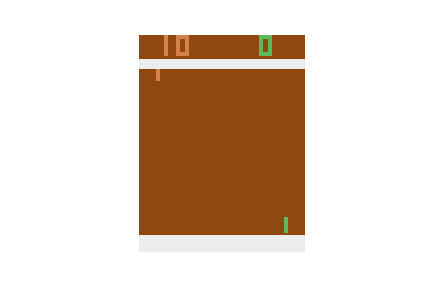

In [6]:
pong_utils.play(env, policy, time=200) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [0]:
def discounted_future_rewards(rewards, ratio=0.999):
    n = rewards.shape[1]
    step = torch.arange(n)[:,None] - torch.arange(n)[None,:]
    ones = torch.ones_like(step)
    zeros = torch.zeros_like(step)
    
    target = torch.where(step >= 0, ones, zeros)
    step = torch.where(step >= 0, step, zeros)    
    discount = target * (ratio ** step)
    discount = torch.tensor(discount.to(device), dtype=torch.float, device=device)
    
    rewards_discounted = torch.mm(rewards, discount)
    return rewards_discounted

In [0]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    rewards = torch.tensor(rewards, dtype=torch.float, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    
    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)

    # discounted cumulative reward
    R_future = discounted_future_rewards(rewards, discount)

    # subtract baseline (= mean of reward)
    R_mean = torch.mean(R_future)
    R_future -= R_mean

    ratio = new_probs / (old_probs + 1e-6)
    ratio_clamped = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    ratio_PPO = torch.where(ratio < ratio_clamped, ratio, ratio_clamped)

    # policy gradient maxmize target
    surrogates = (R_future * ratio_PPO).mean()
    
    # include a regularization term
    # this steers new_policy towards 0.5
    # which prevents policy to become exactly 0 or 1
    # this helps with exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10) + (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
    surrogates += torch.mean(beta*entropy)

    return surrogates

In [0]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

In [14]:
Lsur= clipped_surrogate(policy, prob, state, action, reward)
print(Lsur)

tensor(0.0069, device='cuda:0', grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [15]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500

# widget bar to display progress
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 200
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

#         L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
#                                           epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("\nEpisode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

training loop: N/A% |                                          | ETA:  --:--:--/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
training loop:   4% |#                                         | ETA:   0:30:01


Episode: 20, score: -8.500000
[-10.  -7. -10.  -7.  -7. -10.  -7. -10.]


training loop:   8% |###                                       | ETA:   0:28:04


Episode: 40, score: -8.750000
[ -9. -10.  -9.  -9.  -7.  -7.  -9. -10.]


training loop:  12% |#####                                     | ETA:   0:26:33


Episode: 60, score: -7.750000
[ -9.  -9.  -5.  -7.  -8. -10.  -9.  -5.]


training loop:  16% |######                                    | ETA:   0:25:13


Episode: 80, score: -7.125000
[  0.  -9.  -9.  -8.  -6. -10.  -6.  -9.]


training loop:  20% |########                                  | ETA:   0:23:57


Episode: 100, score: -9.375000
[ -8.  -9. -10. -10. -10. -10. -10.  -8.]


training loop:  24% |##########                                | ETA:   0:22:47


Episode: 120, score: -7.625000
[ -6. -10. -10.  -8.  -5.  -6.  -9.  -7.]


training loop:  28% |###########                               | ETA:   0:21:32


Episode: 140, score: -7.875000
[ -5.  -5. -10.  -8. -10. -10.  -7.  -8.]


training loop:  32% |#############                             | ETA:   0:20:16


Episode: 160, score: -7.875000
[-10.  -5.  -7.  -8. -10.  -5.  -9.  -9.]


training loop:  36% |###############                           | ETA:   0:19:05


Episode: 180, score: -7.875000
[-10.  -8.  -9.  -6.  -6.  -9.  -9.  -6.]


training loop:  40% |################                          | ETA:   0:17:52


Episode: 200, score: -9.375000
[-10. -10. -10. -10.  -9.  -9.  -9.  -8.]


training loop:  44% |##################                        | ETA:   0:16:42


Episode: 220, score: -7.625000
[ -5. -10.  -8. -10.  -5.  -7.  -7.  -9.]


training loop:  48% |####################                      | ETA:   0:15:30


Episode: 240, score: -8.500000
[ -2. -10.  -7. -10. -10. -10.  -9. -10.]


training loop:  52% |#####################                     | ETA:   0:14:18


Episode: 260, score: -9.250000
[-10. -10.  -9.  -9.  -9.  -8. -10.  -9.]


training loop:  56% |#######################                   | ETA:   0:13:06


Episode: 280, score: -7.500000
[ -5.  -6. -10. -10.  -7.  -7.  -8.  -7.]


training loop:  60% |#########################                 | ETA:   0:11:55


Episode: 300, score: -8.250000
[-10.  -7.  -8. -10.  -8.  -8.  -6.  -9.]


training loop:  64% |##########################                | ETA:   0:10:43


Episode: 320, score: -8.125000
[ -8. -10.  -8.  -8.  -5. -10.  -7.  -9.]


training loop:  68% |############################              | ETA:   0:09:31


Episode: 340, score: -7.875000
[ -7.  -5. -10.  -6.  -7.  -9. -10.  -9.]


training loop:  72% |##############################            | ETA:   0:08:20


Episode: 360, score: -8.500000
[-10.  -7.  -6.  -9.  -7.  -9. -10. -10.]


training loop:  76% |###############################           | ETA:   0:07:09


Episode: 380, score: -8.875000
[ -9.  -8. -10.  -6. -10. -10. -10.  -8.]


training loop:  80% |#################################         | ETA:   0:05:57


Episode: 400, score: -9.000000
[-10.  -9.  -9.  -7. -10. -10. -10.  -7.]


training loop:  84% |###################################       | ETA:   0:04:45


Episode: 420, score: -8.375000
[ -7.  -9.  -7.  -9. -10.  -6.  -9. -10.]


training loop:  88% |####################################      | ETA:   0:03:34


Episode: 440, score: -8.125000
[-10.  -9. -10.  -7. -10.  -3. -10.  -6.]


training loop:  92% |######################################    | ETA:   0:02:22


Episode: 460, score: -9.375000
[-10. -10.  -9.  -9. -10. -10. -10.  -7.]


training loop:  96% |########################################  | ETA:   0:01:11


Episode: 480, score: -8.375000
[ -8.  -9. -10.  -7. -10. -10.  -9.  -4.]


training loop: 100% |##########################################| Time:  0:29:47



Episode: 500, score: -8.000000
[-10.  -2.  -9.  -8. -10.  -6. -10.  -9.]



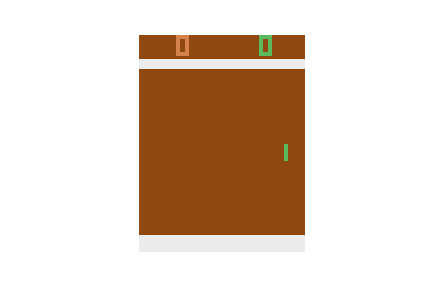
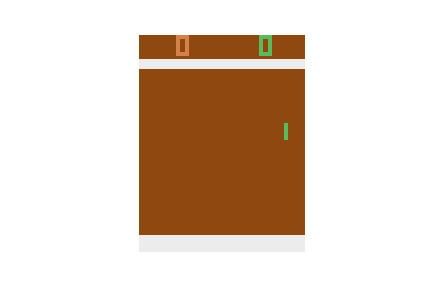
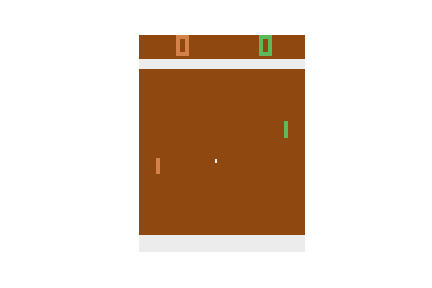
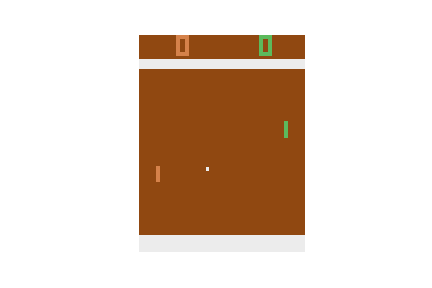
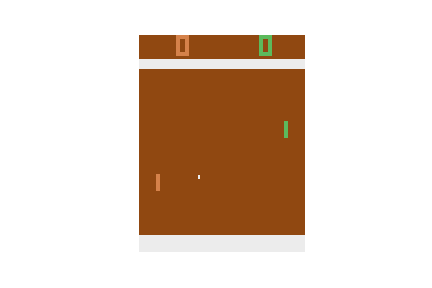
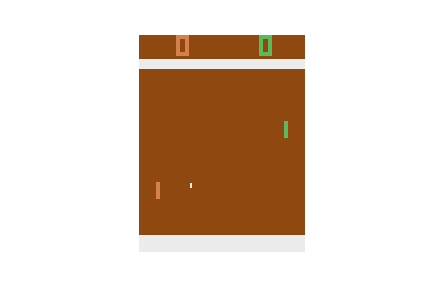
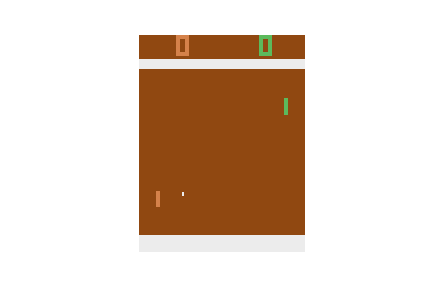
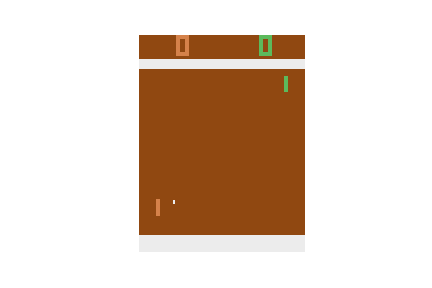
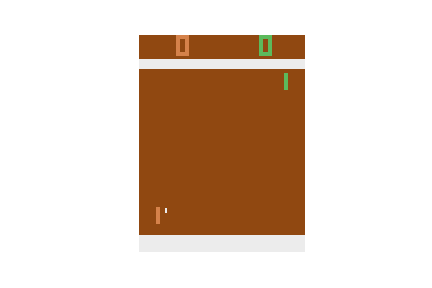
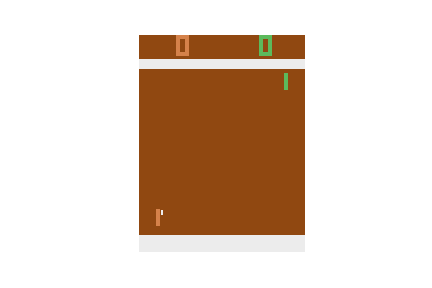
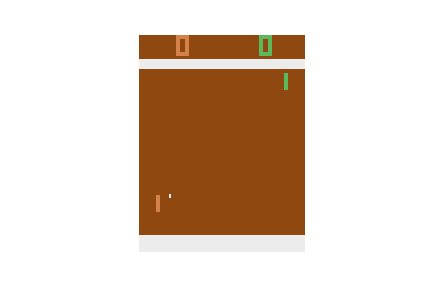
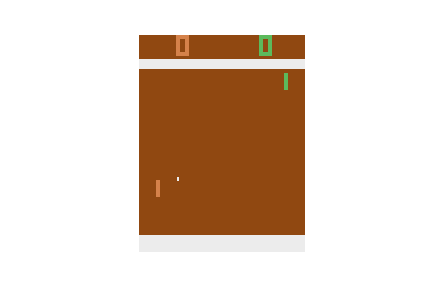
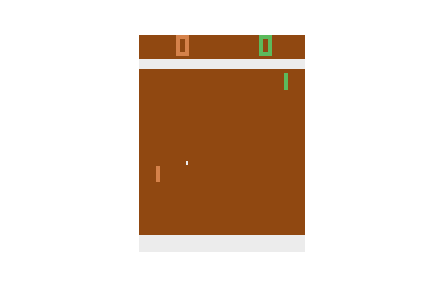
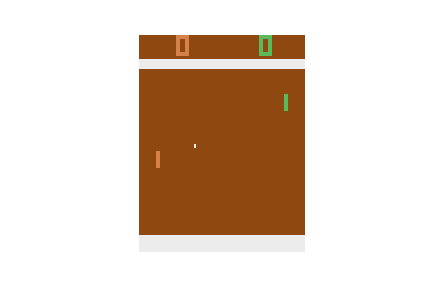
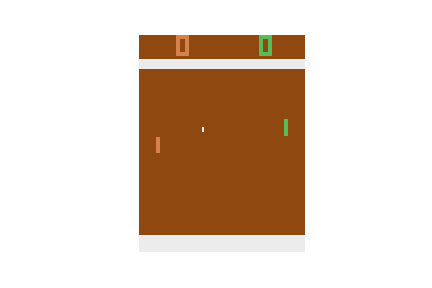
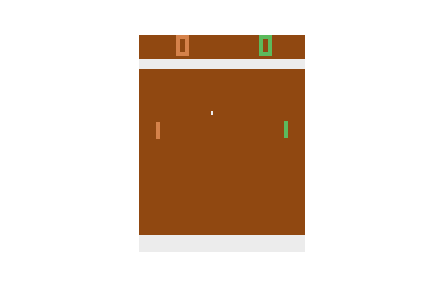
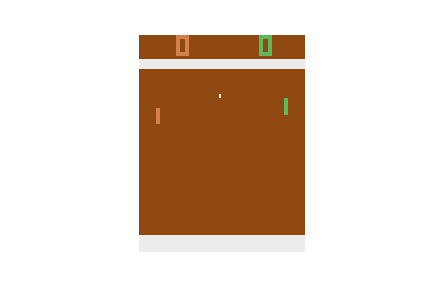
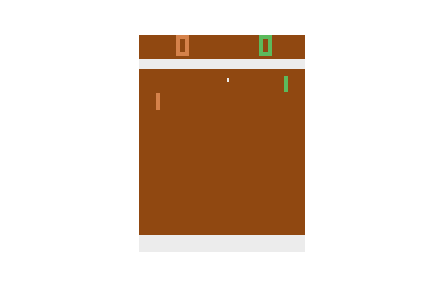
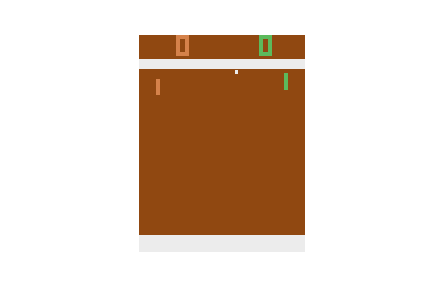
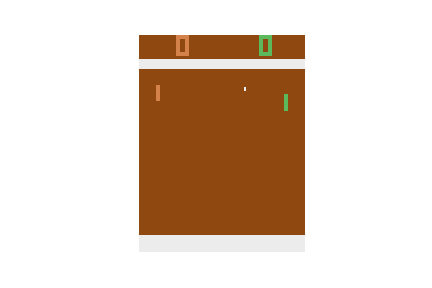
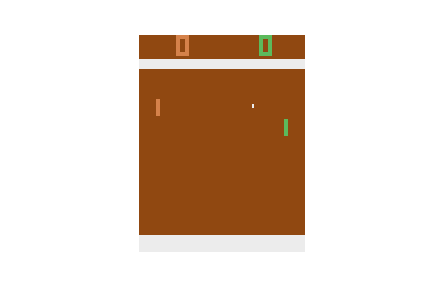
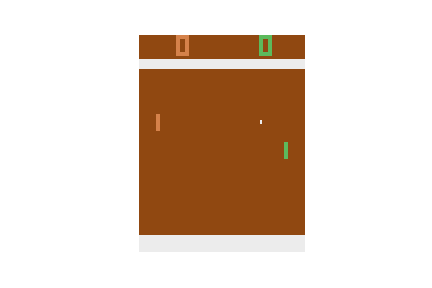
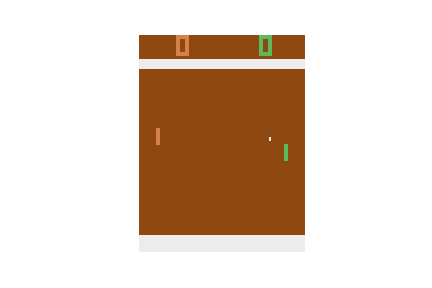
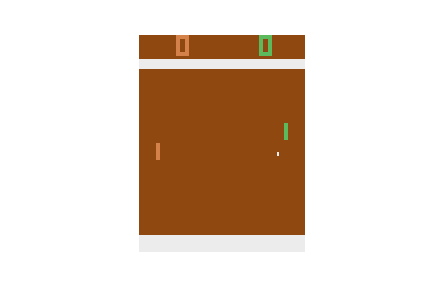
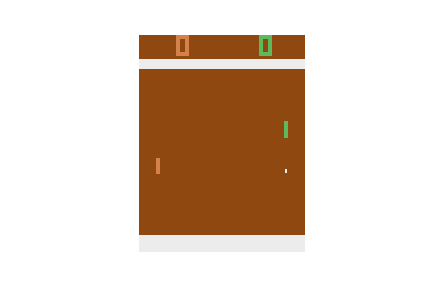
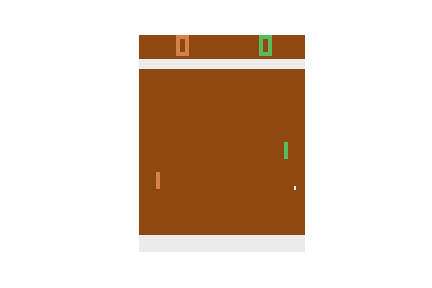
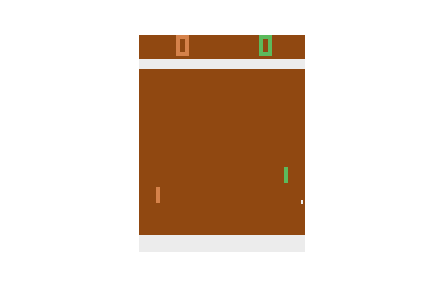
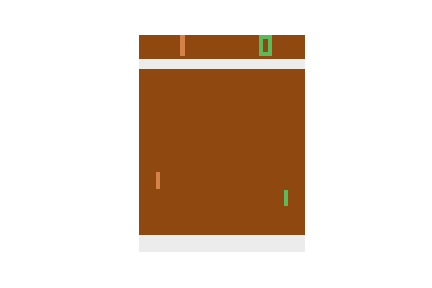
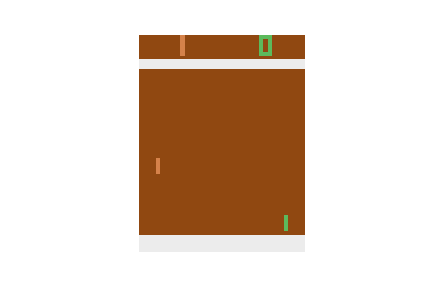
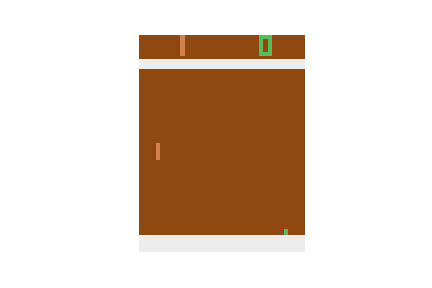
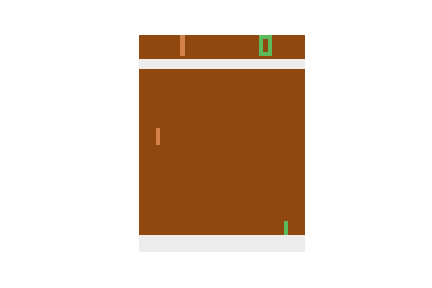
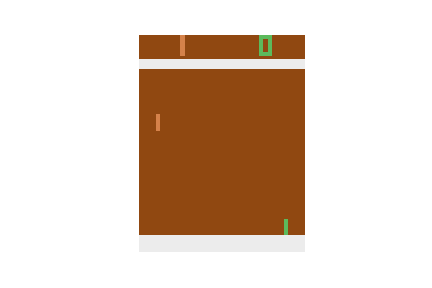
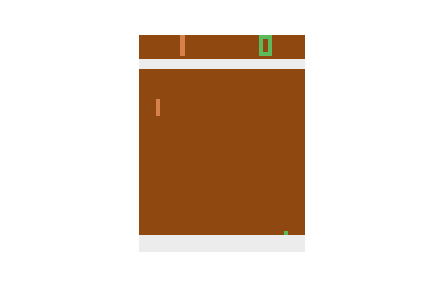
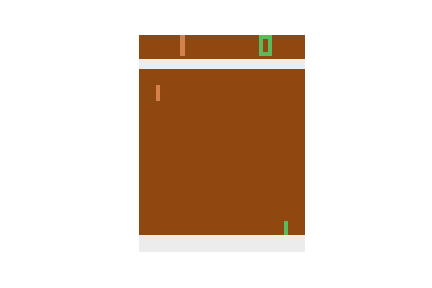
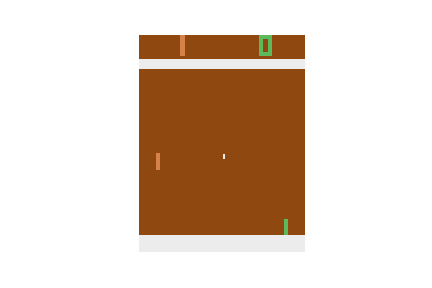
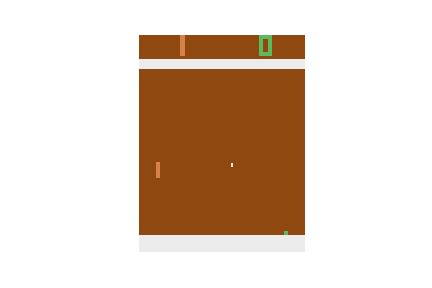
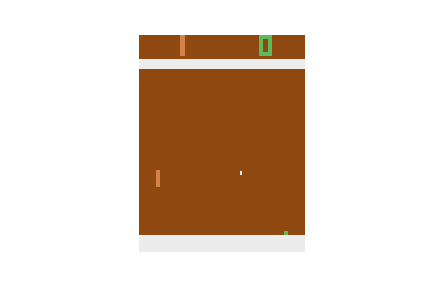
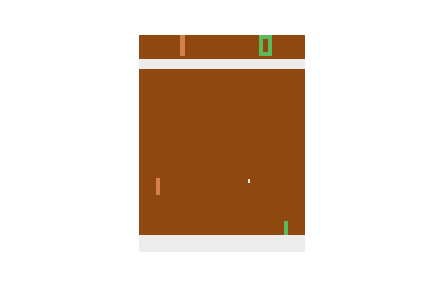
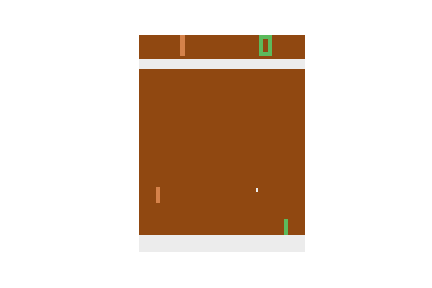
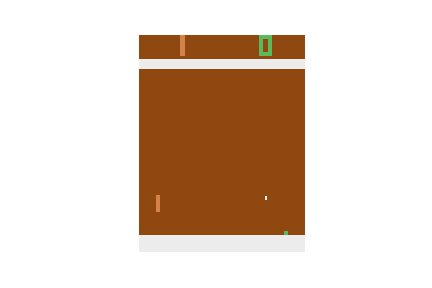
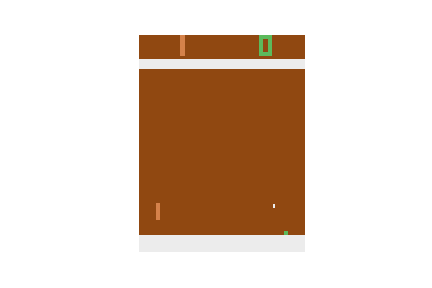
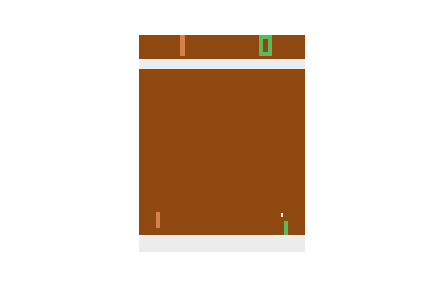
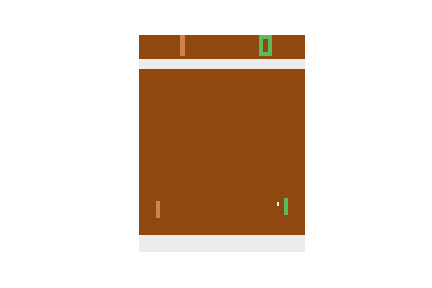
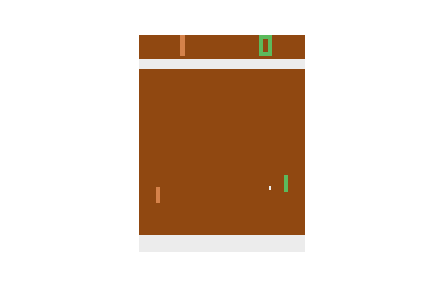
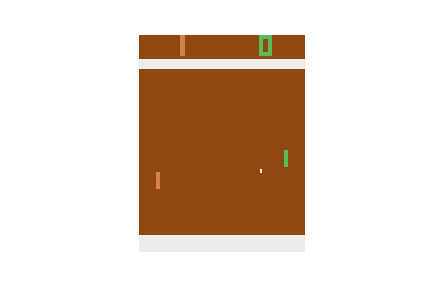
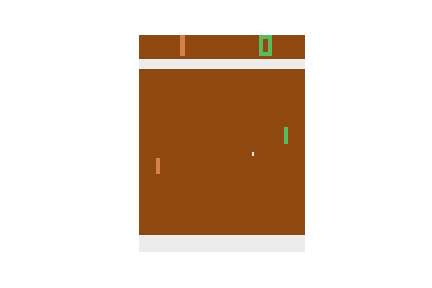
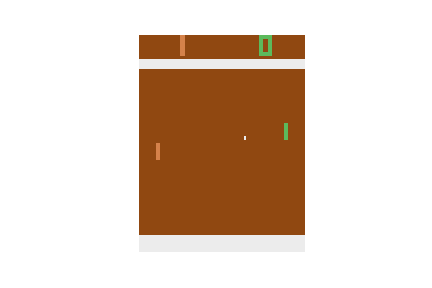
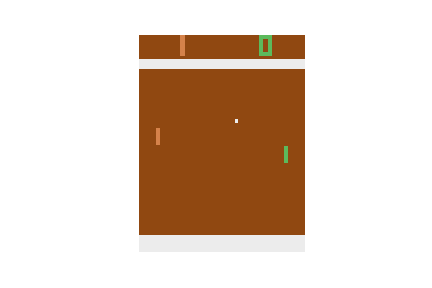
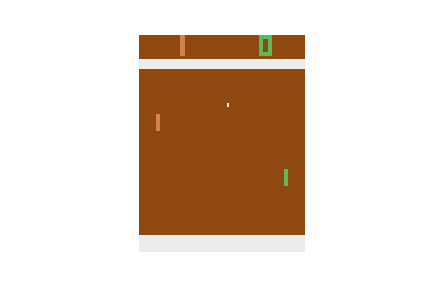
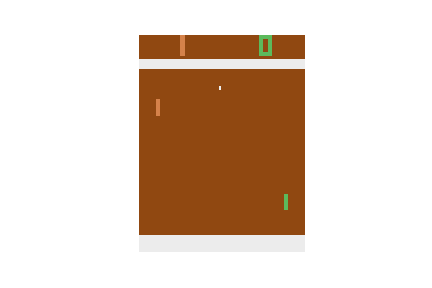
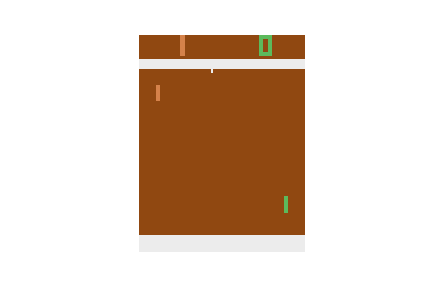
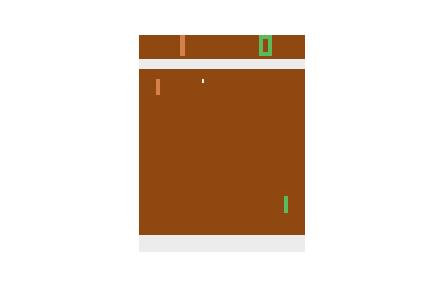
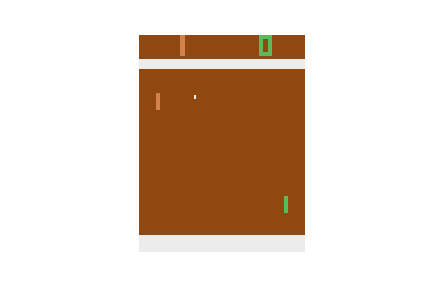
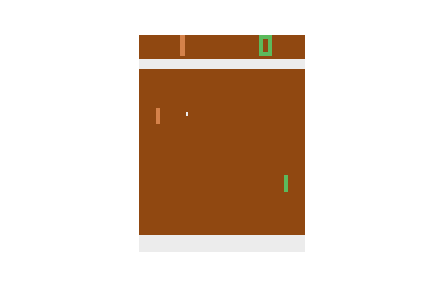
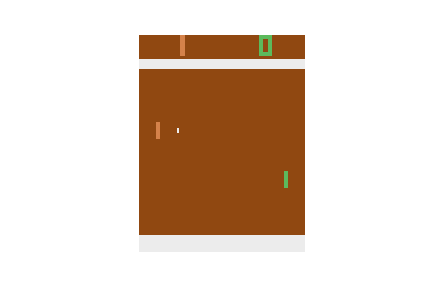
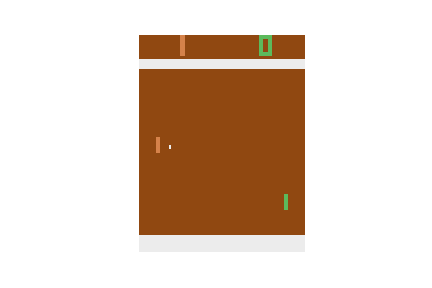
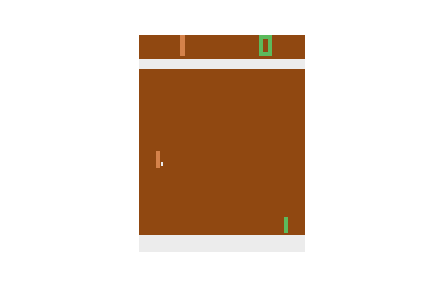
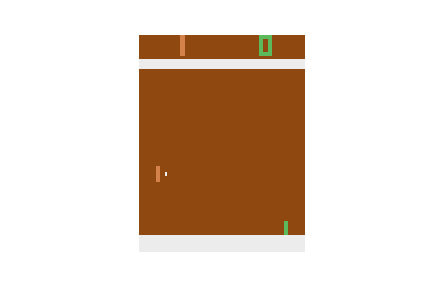
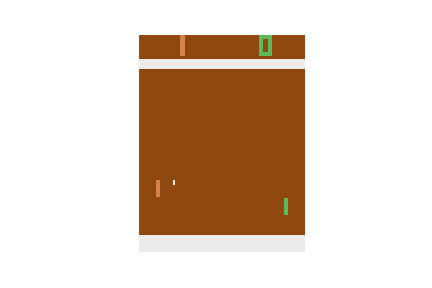
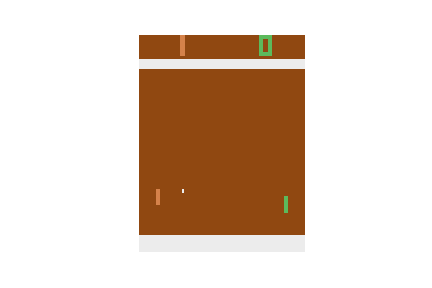
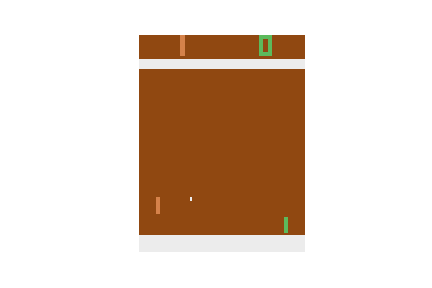
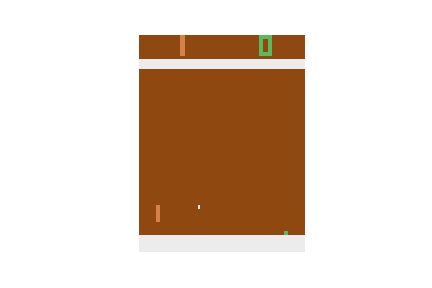
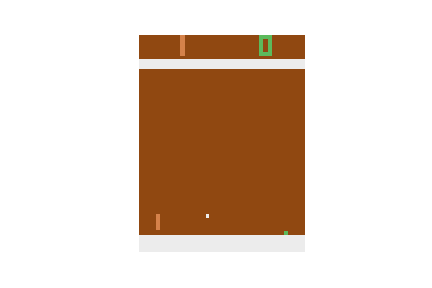
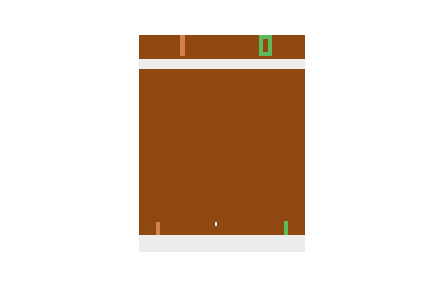
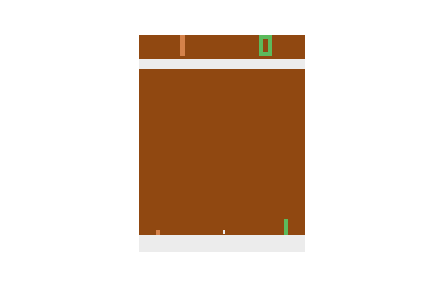
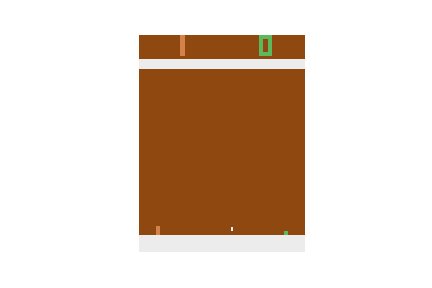
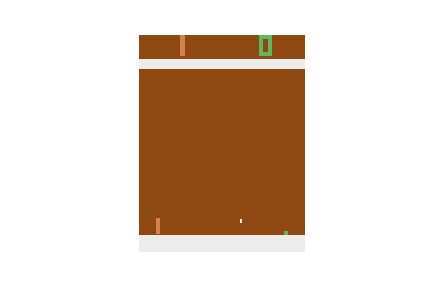
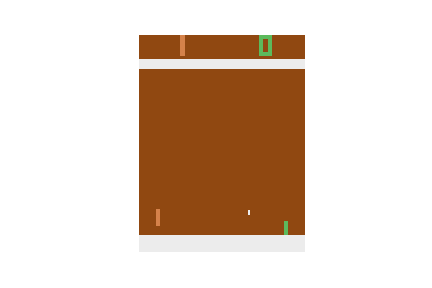
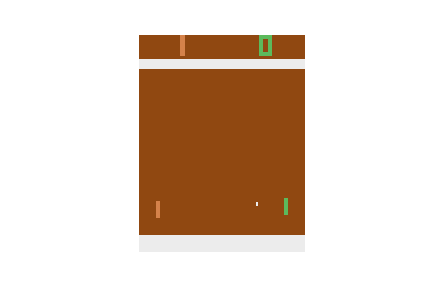
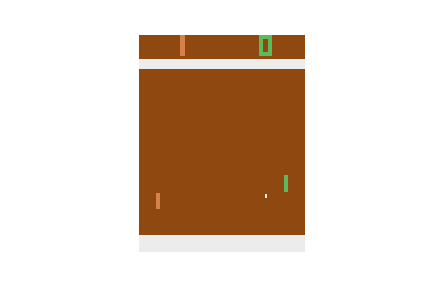
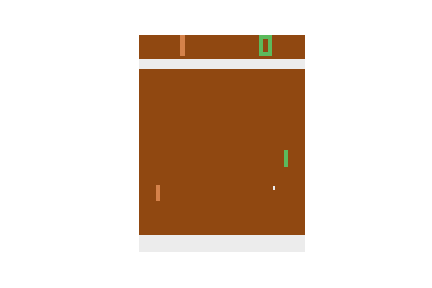
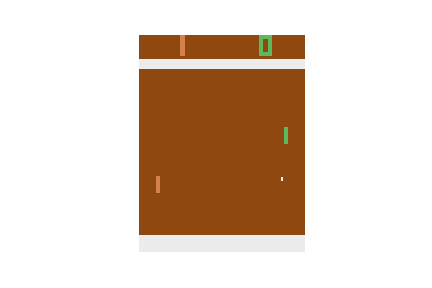
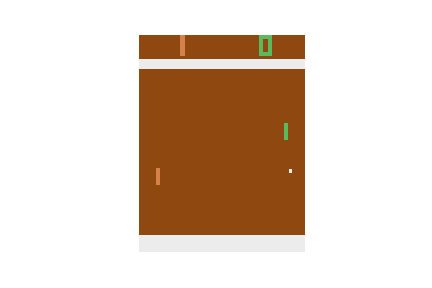
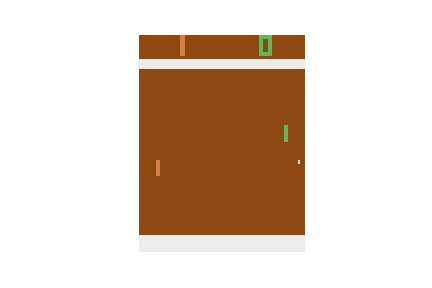
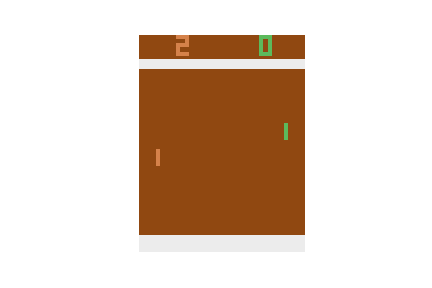
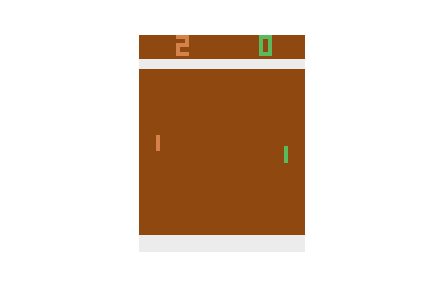
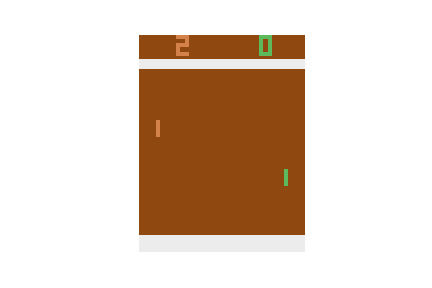
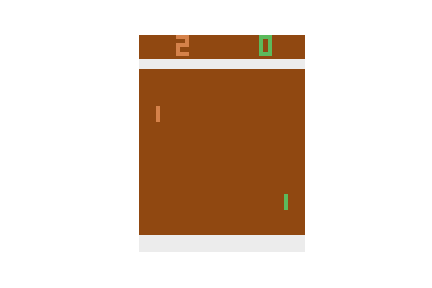
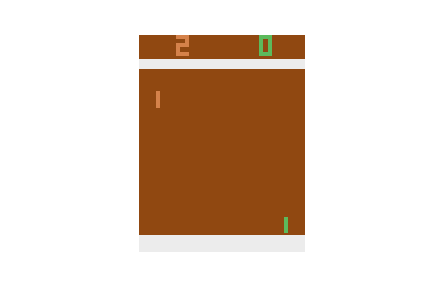
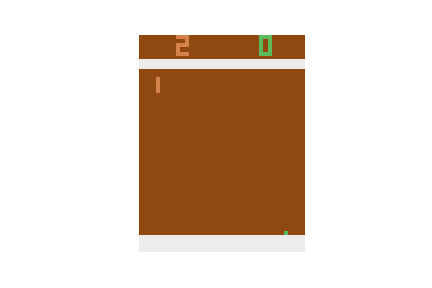
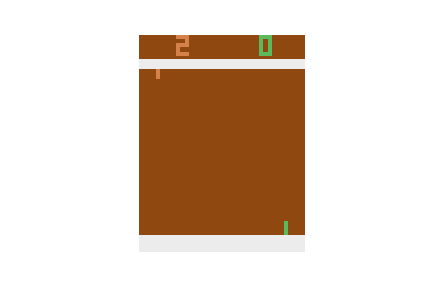
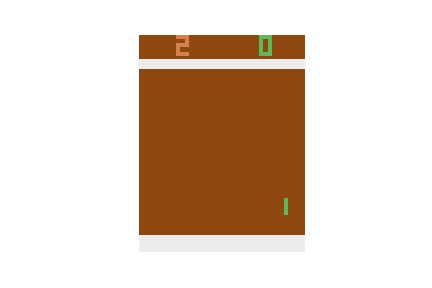
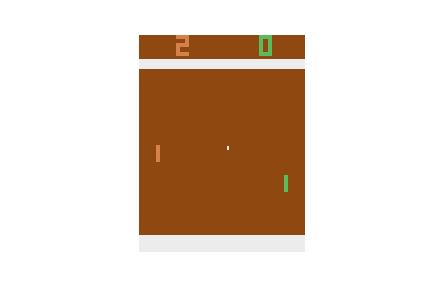
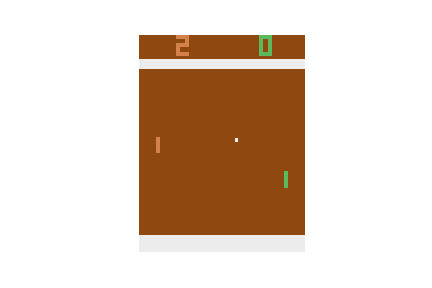
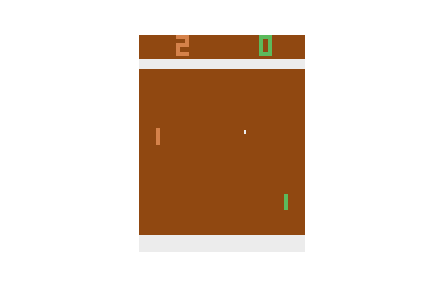
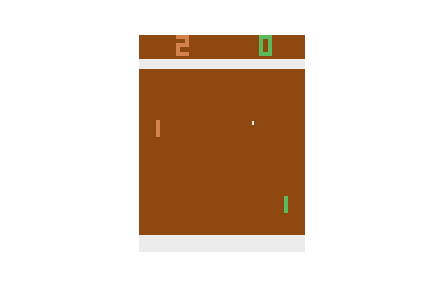
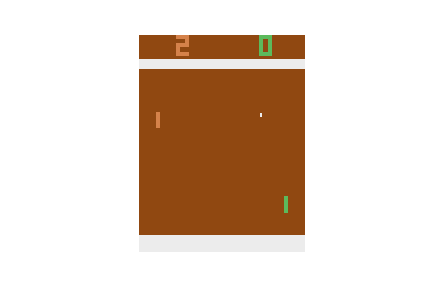
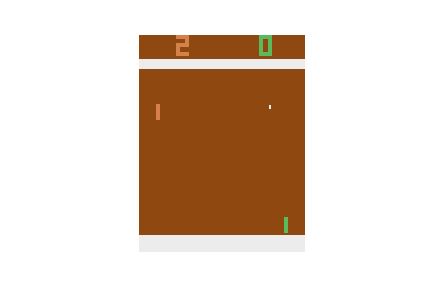
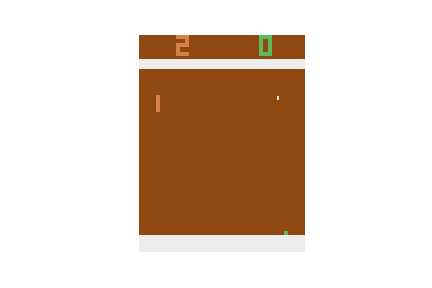
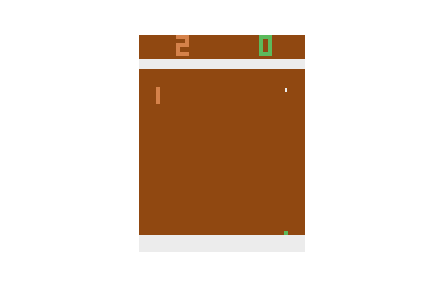
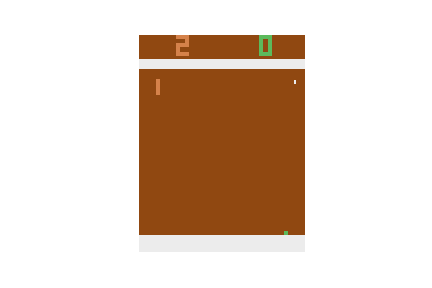
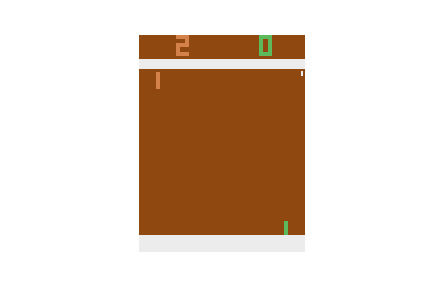
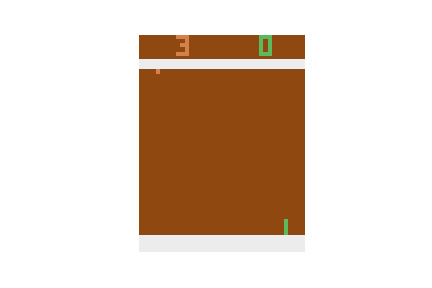
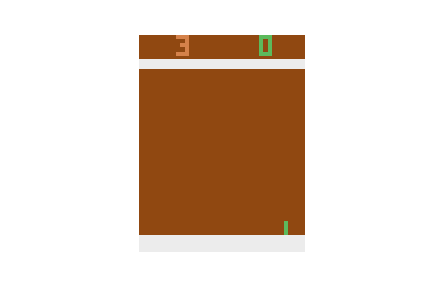
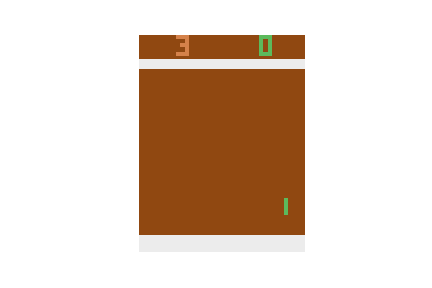
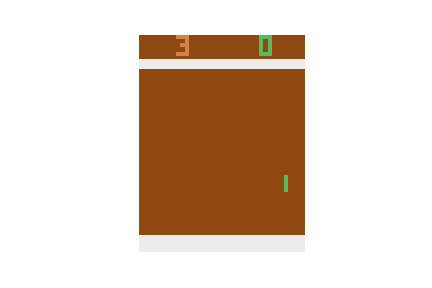
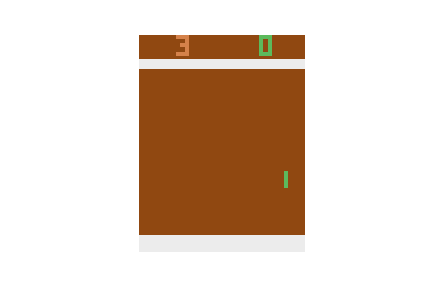
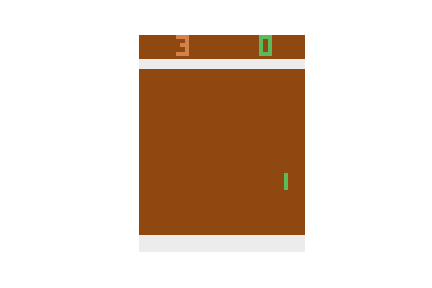
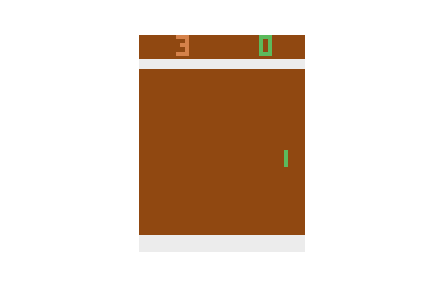
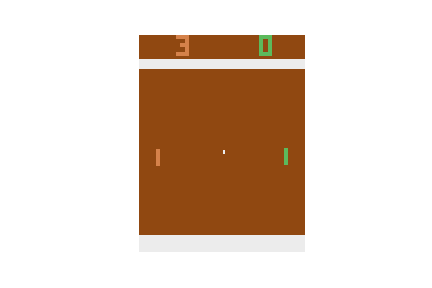
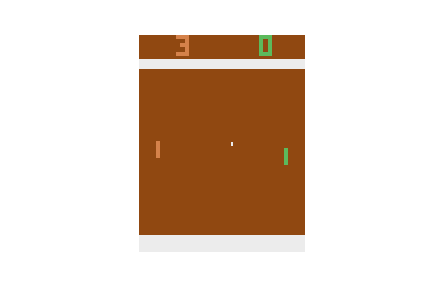
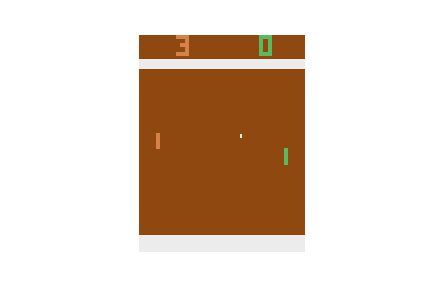
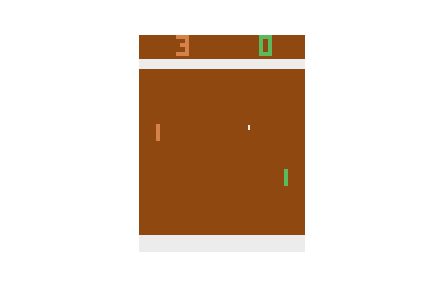
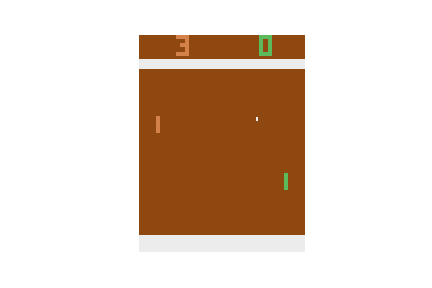
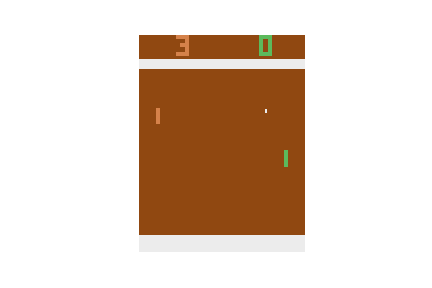
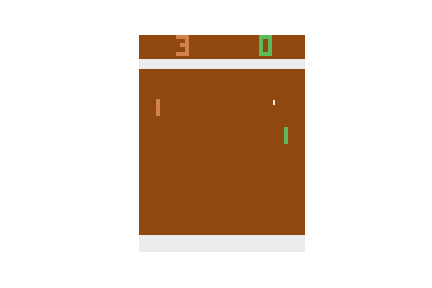
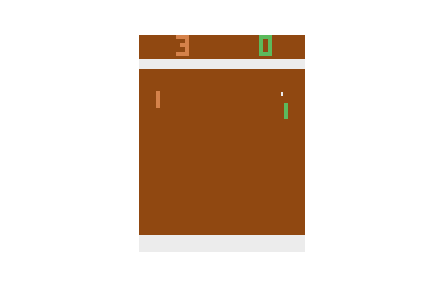
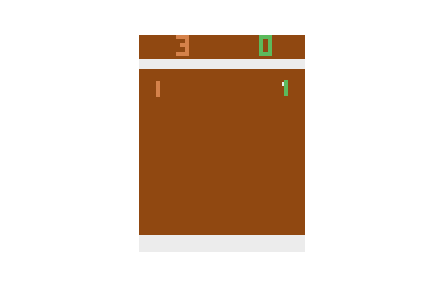
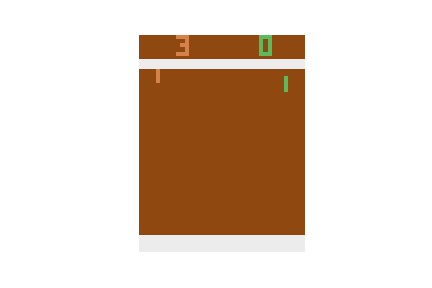
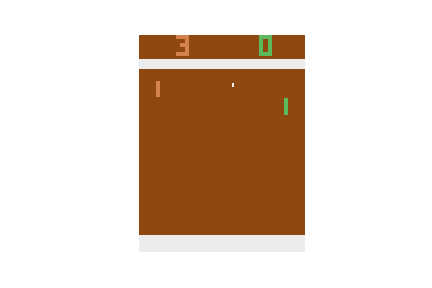
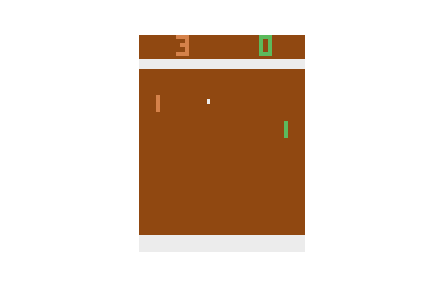
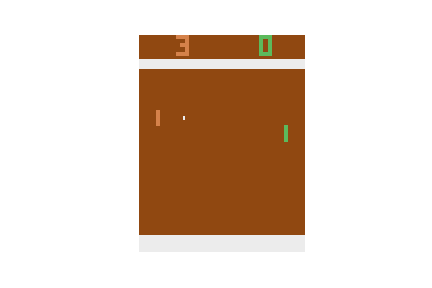
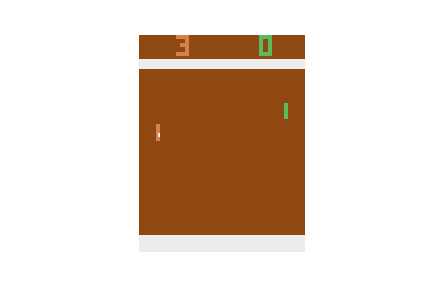
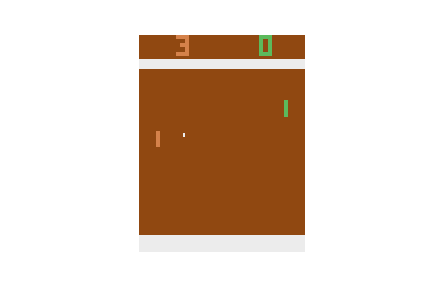
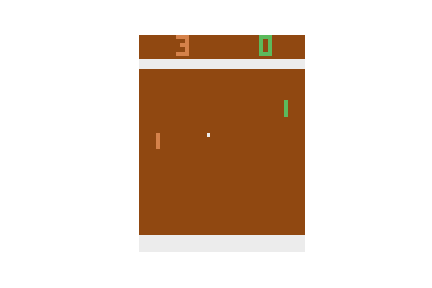
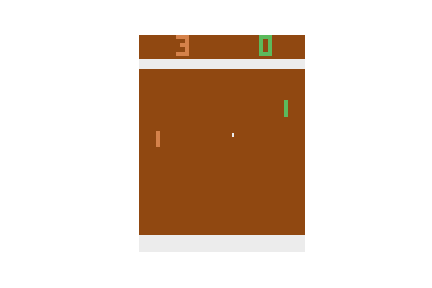
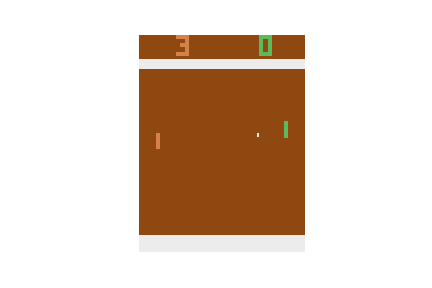
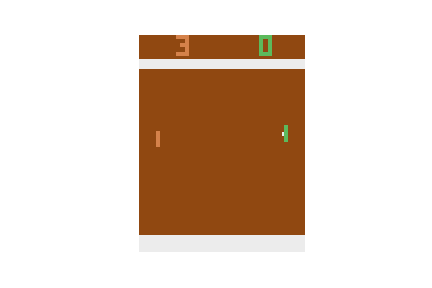
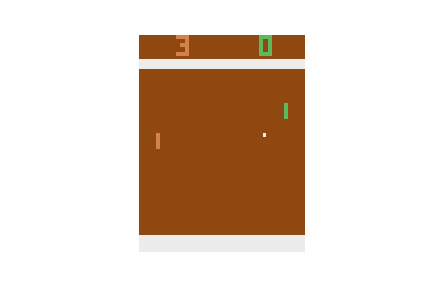
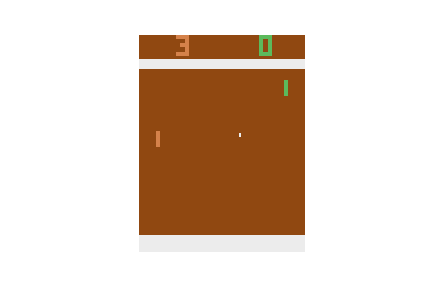
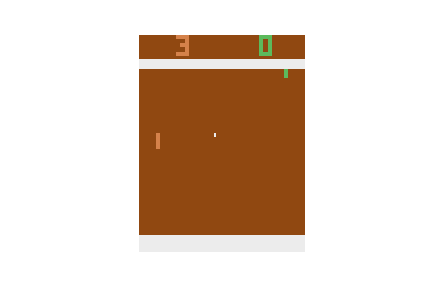
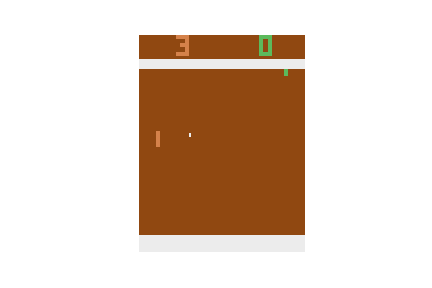
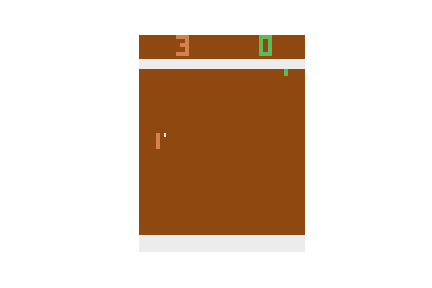
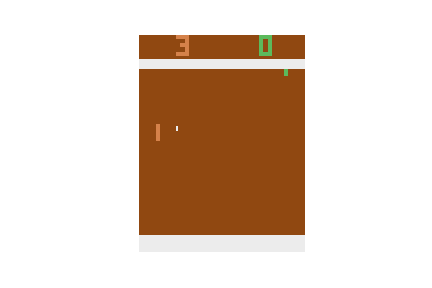
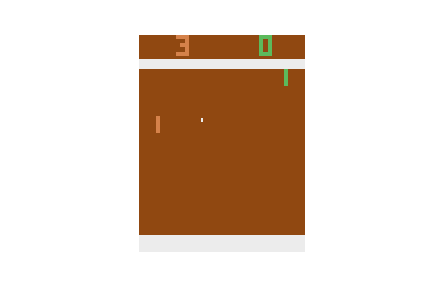
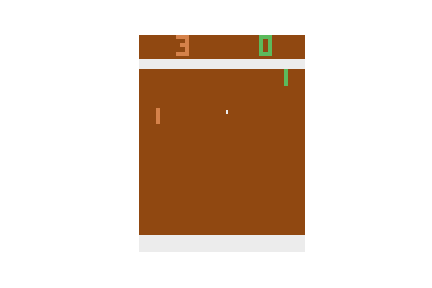
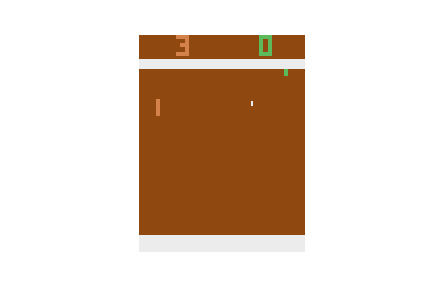
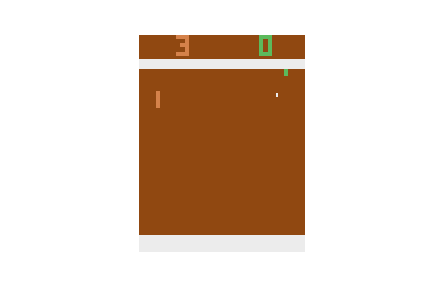
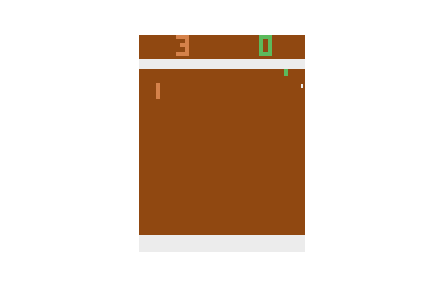
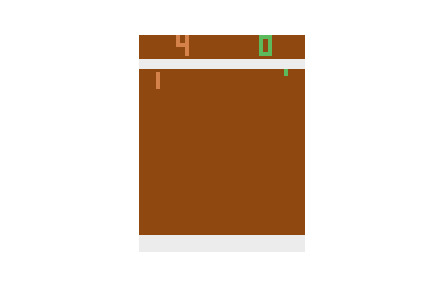
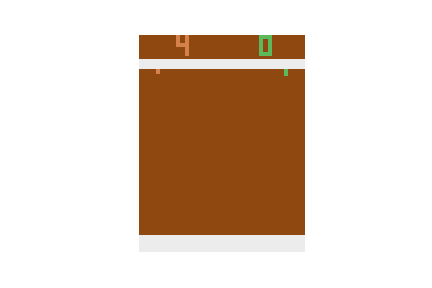
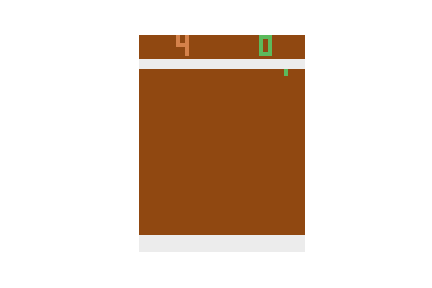
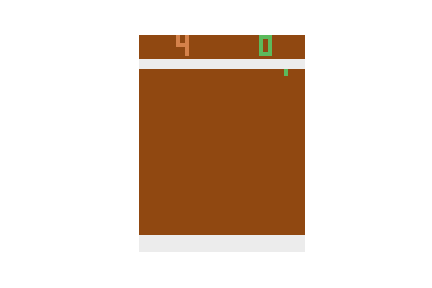
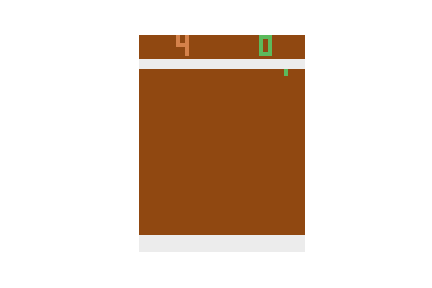
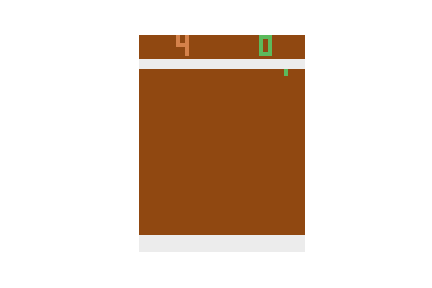
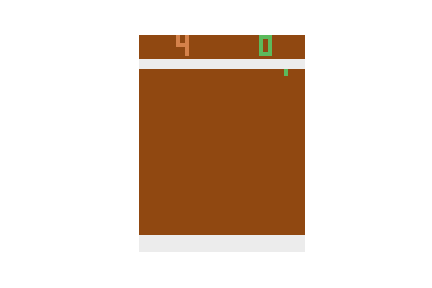
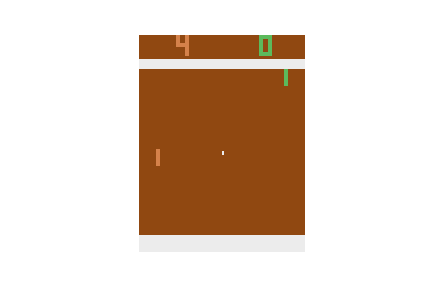
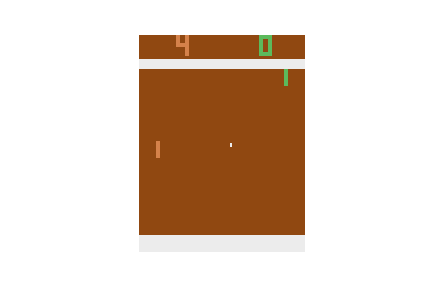
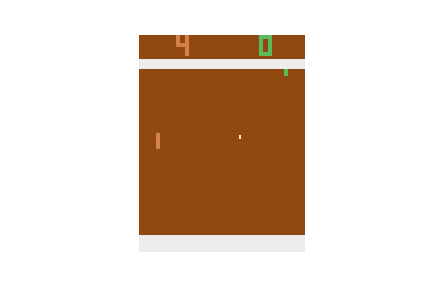
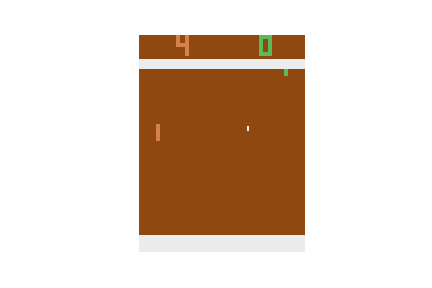
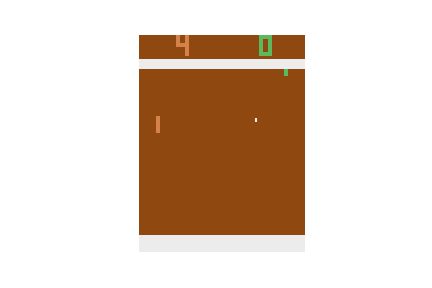
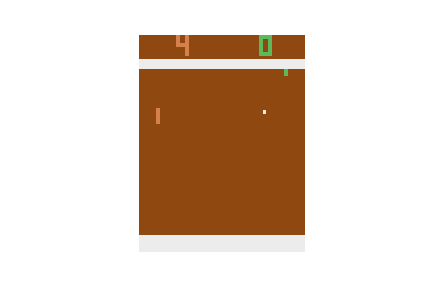
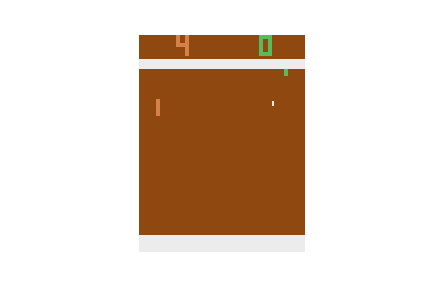
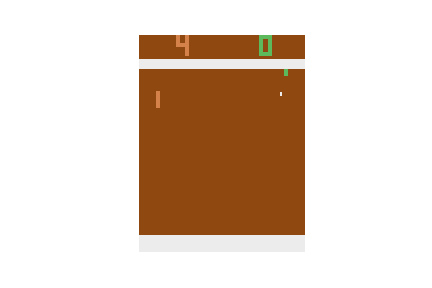
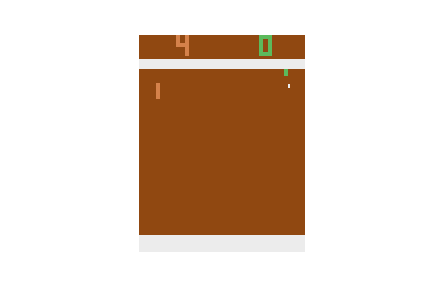
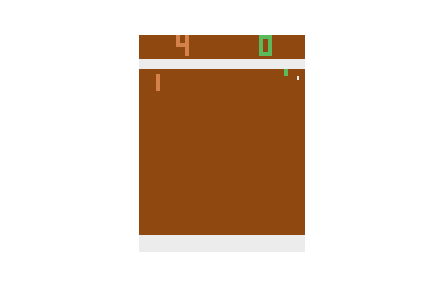
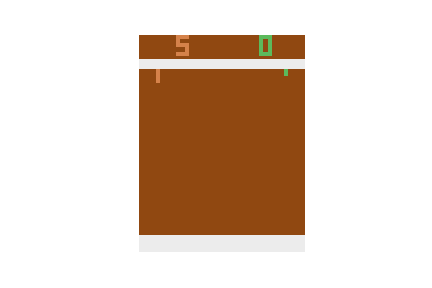
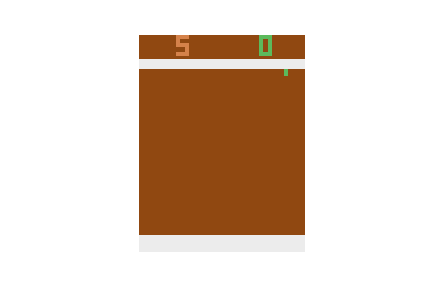
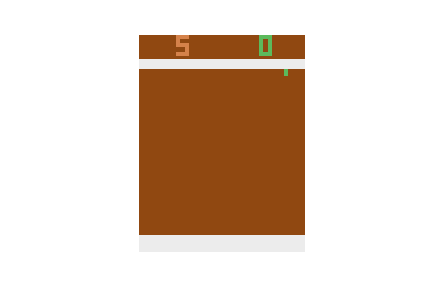
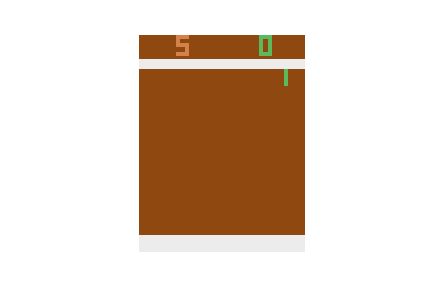
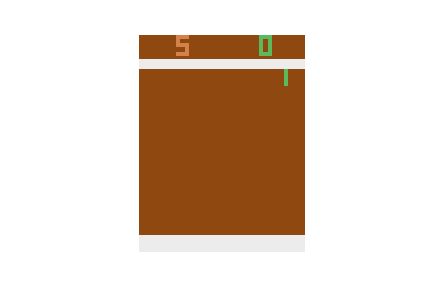
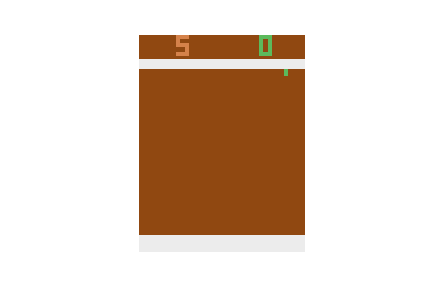
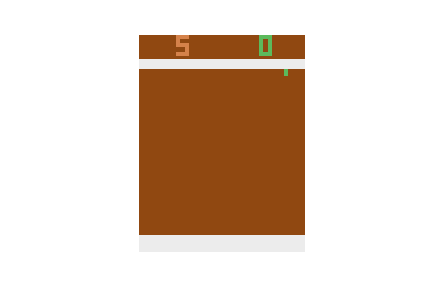
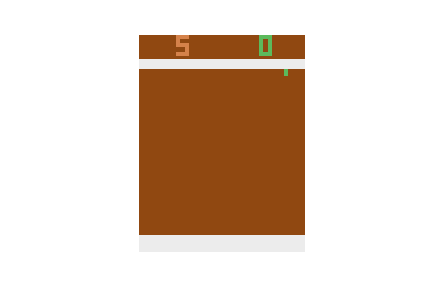
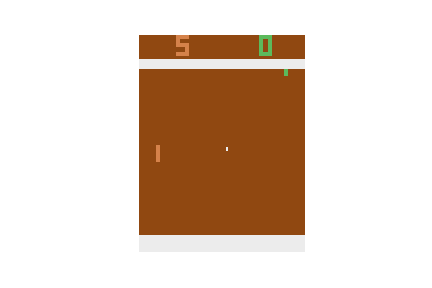
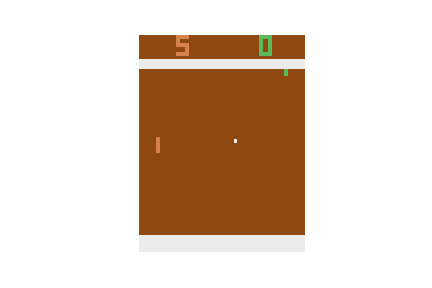
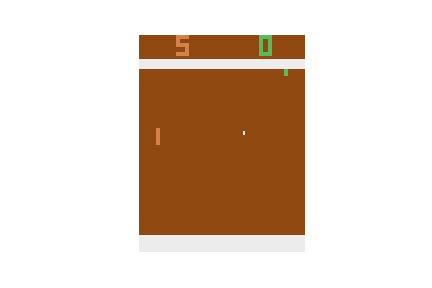
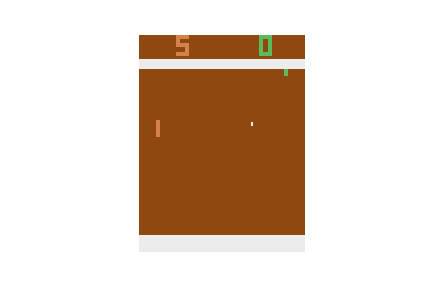
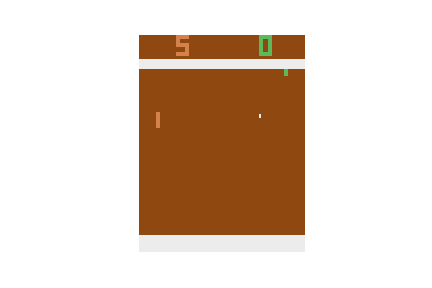
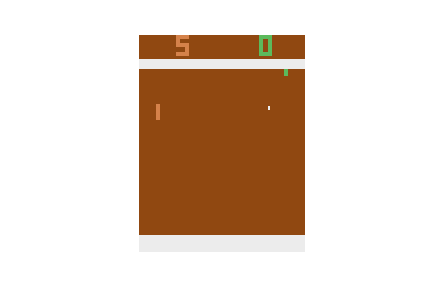
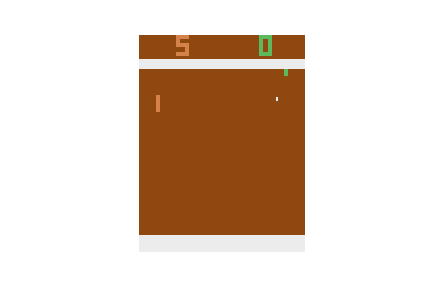
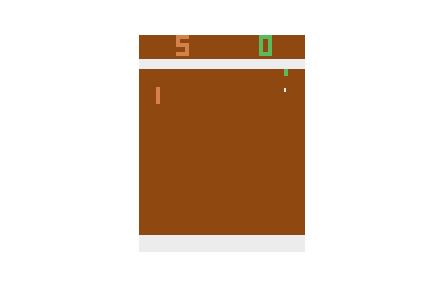
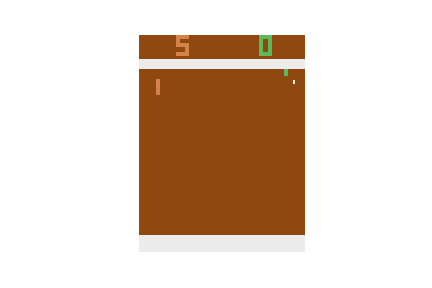
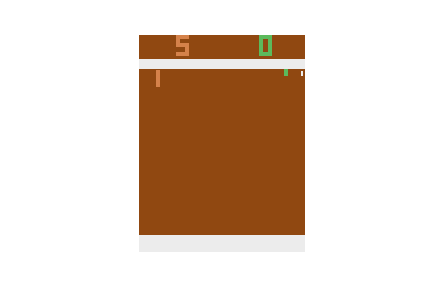
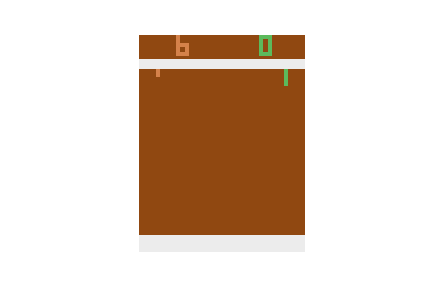
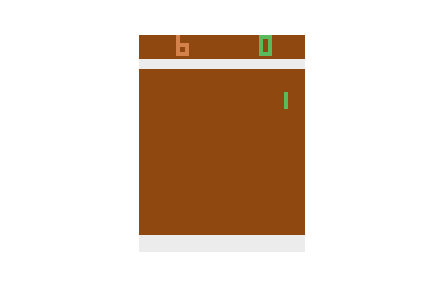
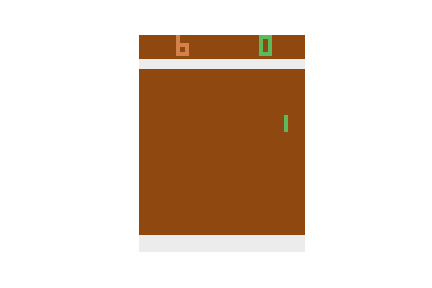
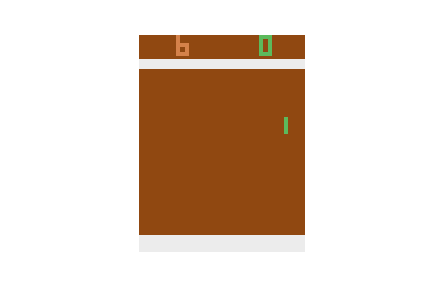
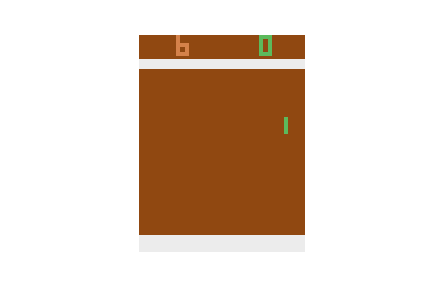
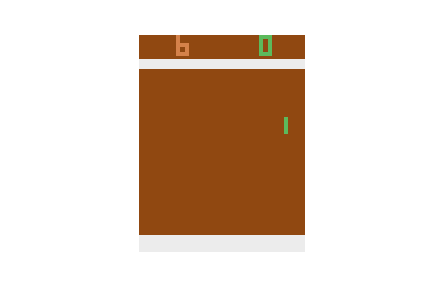
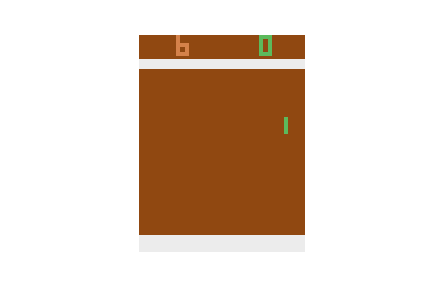
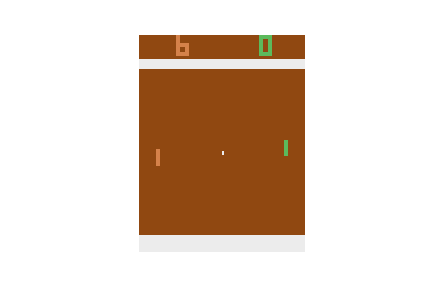
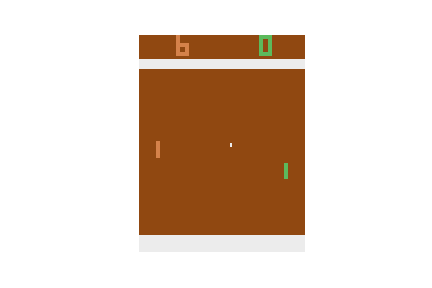
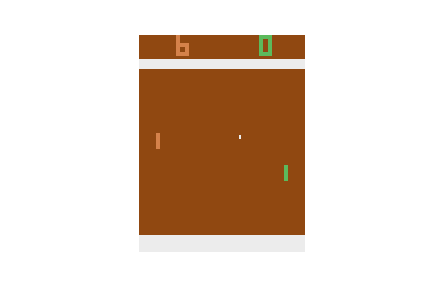
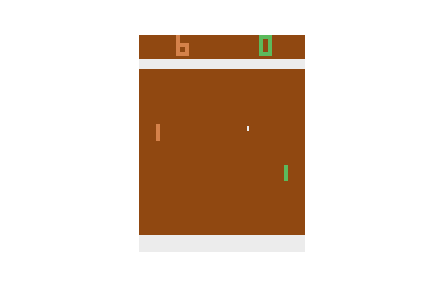
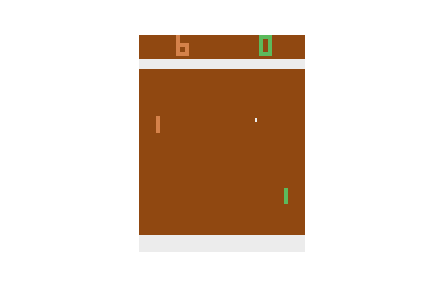
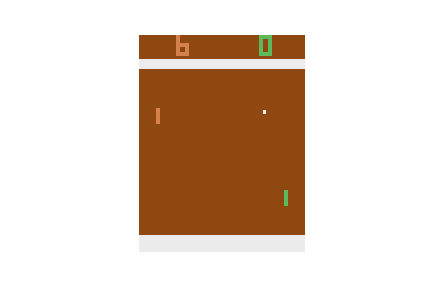
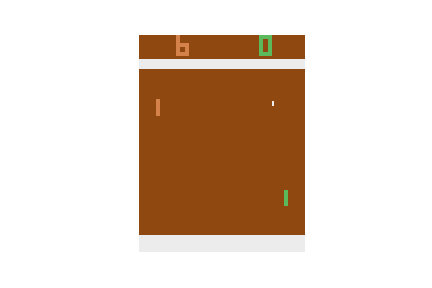
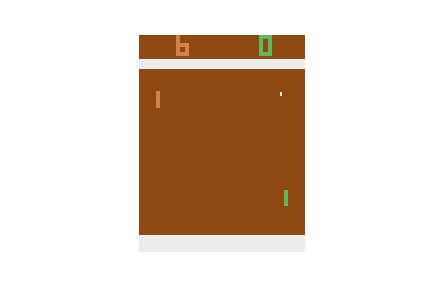
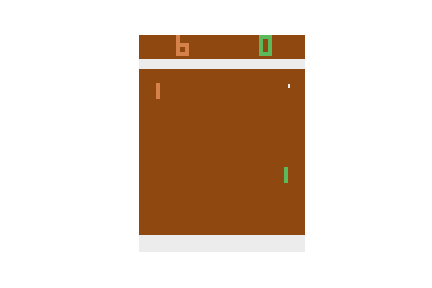
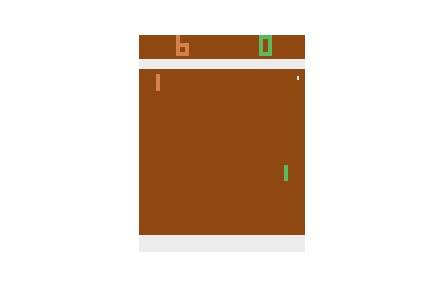
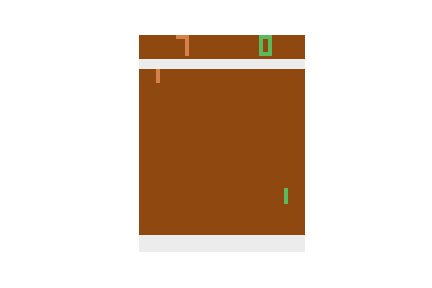
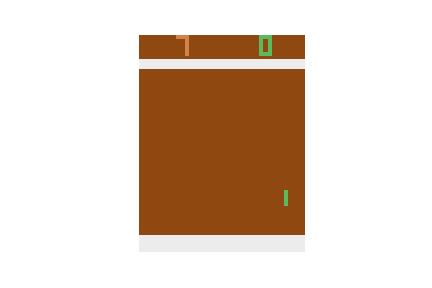
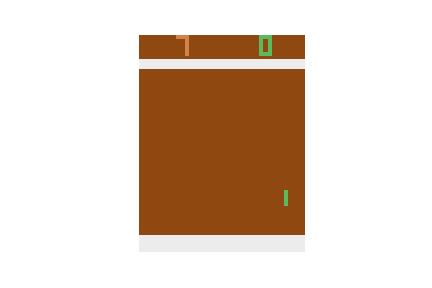
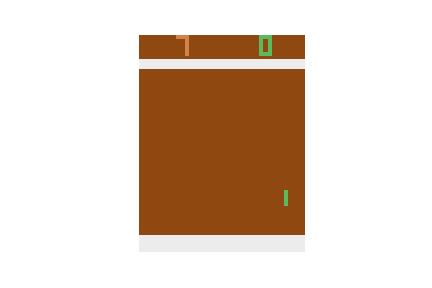
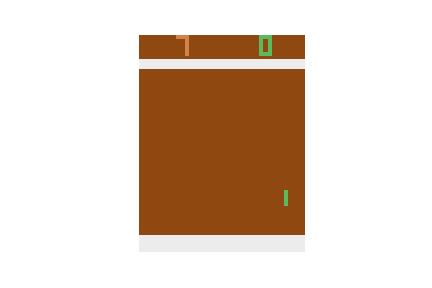
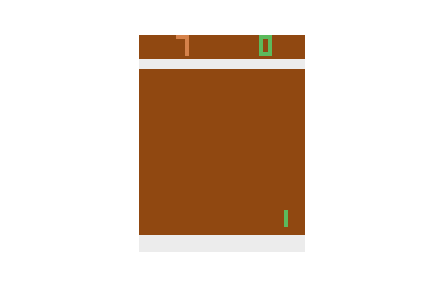
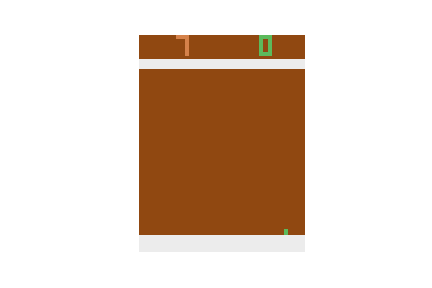
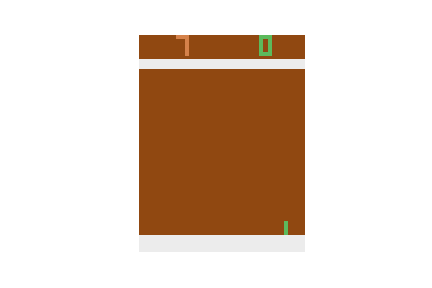
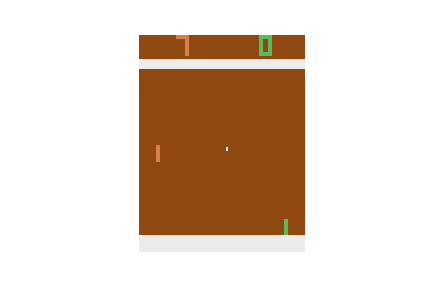
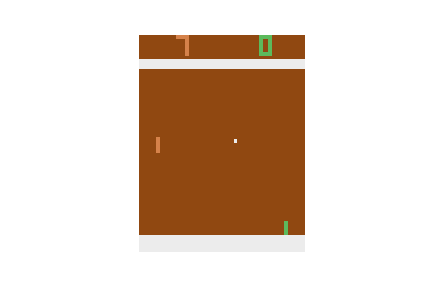
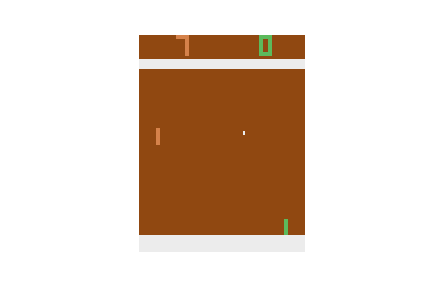
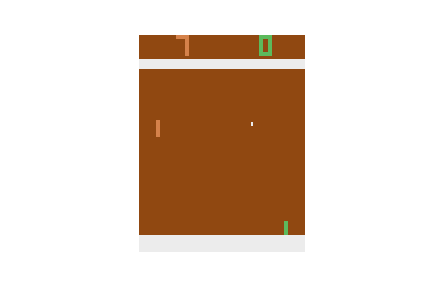
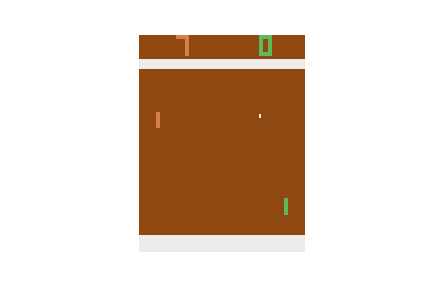
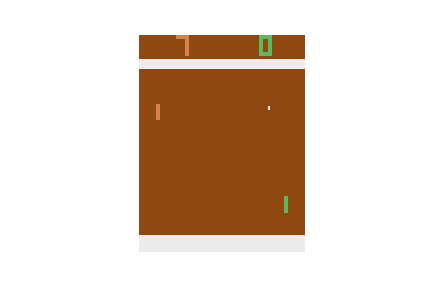
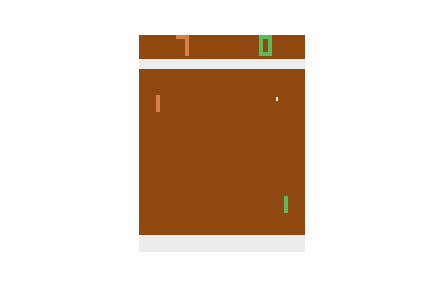
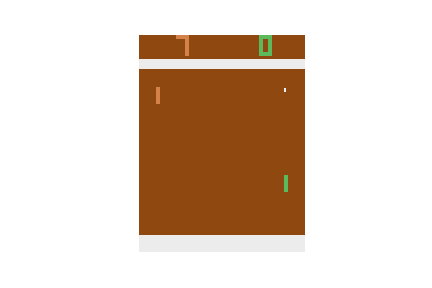
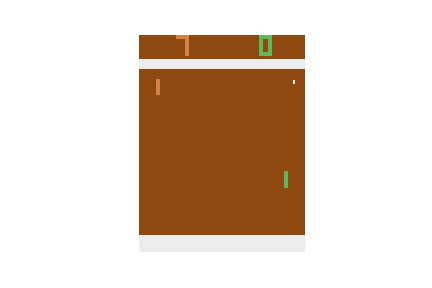
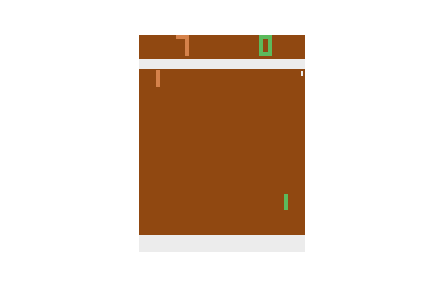
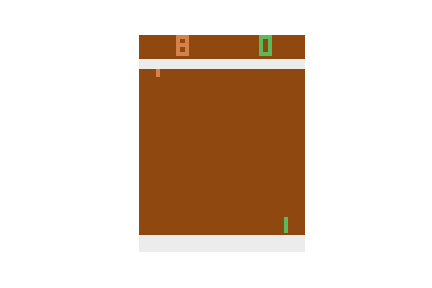

In [16]:
pong_utils.play(env, policy, time=200) 

In [17]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
